# Market Mix Modelling for an e-commerce firm

#### Problem statment:

Eleckart, an e-commerce firm based out of Ontario, Canada spends a significant amount of money on marketing. The marketing budget is spent on commercials, online campaigns and pricing & promotion strategies. Eleckart’s CFO feels that the money spent over the last 12 months did not have enough impact and that the budget can be cut or optimally reallocated across marketing levers to improve revenue.

#### Goal:
As part of the marketing team, which is working on budget optimisation, we need to develop a market mix model with the following objectives:

- Observe the actual impact of different marketing variables over the last one year
- Recommend the optimal budget allocation for different marketing levers for the next year


In [1]:
# import libraties
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm  
from statsmodels.stats.outliers_influence import variance_inflation_factor

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# Phase 1: Understanding the data

## 1.1 Understanding order level data

In [2]:
products = pd.read_csv('ConsumerElectronics.csv', 
                        encoding='ISO-8859-1',
                        dtype={'order_id':'Int64', 'order_item_id':'Int64','cust_id':'str','pincode':'str','gmv':'str'},
                        parse_dates =['order_date'])

In [3]:
products.head()

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla
0,ACCCX3S58G7B5F6P,2015-10-17 15:11:54,2015,10,3419300926147000,3419300926147000,6400,1,\N,\N,COD,5,-1.01299130778588E+018,-7.79175582905735E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0
1,ACCCX3S58G7B5F6P,2015-10-19 10:07:22,2015,10,1420830839915200,1420830839915200,6900,1,\N,\N,COD,7,-8.99032457905512E+018,7.33541149097431E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0
2,ACCCX3S5AHMF55FV,2015-10-20 15:45:56,2015,10,2421912925714800,2421912925714800,1990,1,\N,\N,COD,10,-1.0404429420466E+018,-7.47768776228657E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4416592101738400,4416592101738400,1690,1,\N,\N,Prepaid,4,-7.60496084352714E+018,-5.83593163877661E+018,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3
4,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,4419525153426400,4419525153426400,1618,1,\N,\N,Prepaid,6,2.8945572083453E+018,5.34735360997242E+017,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3


In [4]:
products['gmv']=pd.to_numeric(products.gmv,errors='coerce')
products[products.gmv.isna()].fsn_id.count()

4904

In [5]:
products['cust_id']=pd.to_numeric(products.cust_id,errors='coerce')
products[products.cust_id.isna()].fsn_id.count()

4904

In [6]:
products['pincode']=pd.to_numeric(products.pincode,errors='coerce')
products[products.pincode.isna()].fsn_id.count()

4904

In [7]:
products['deliverybdays']=pd.to_numeric(products.deliverybdays,errors='coerce')
products[products.deliverybdays.isna()].fsn_id.count()

1312972

In [8]:
products['deliverycdays']=pd.to_numeric(products.deliverycdays,errors='coerce')
products[products.deliverycdays.isna()].fsn_id.count()

1312971

In [9]:
products.head()

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla
0,ACCCX3S58G7B5F6P,2015-10-17 15:11:54,2015,10,3419300926147000,3419300926147000,6400.0,1,NaN,NaN,COD,5,-1.012991e+18,-7.791756e+18,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0
1,ACCCX3S58G7B5F6P,2015-10-19 10:07:22,2015,10,1420830839915200,1420830839915200,6900.0,1,NaN,NaN,COD,7,-8.990325e+18,7.335411e+18,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0
2,ACCCX3S5AHMF55FV,2015-10-20 15:45:56,2015,10,2421912925714800,2421912925714800,1990.0,1,NaN,NaN,COD,10,-1.040443e+18,-7.477688e+18,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4416592101738400,4416592101738400,1690.0,1,NaN,NaN,Prepaid,4,-7.604961e+18,-5.835932e+18,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3
4,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,4419525153426400,4419525153426400,1618.0,1,NaN,NaN,Prepaid,6,2.894557e+18,5.347354e+17,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3


In [10]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648824 entries, 0 to 1648823
Data columns (total 20 columns):
fsn_id                             1648824 non-null object
order_date                         1648824 non-null datetime64[ns]
Year                               1648824 non-null int64
Month                              1648824 non-null int64
order_id                           1648824 non-null int64
order_item_id                      1648824 non-null int64
gmv                                1643920 non-null float64
units                              1648824 non-null int64
deliverybdays                      335852 non-null float64
deliverycdays                      335853 non-null float64
s1_fact.order_payment_type         1648824 non-null object
sla                                1648824 non-null int64
cust_id                            1643920 non-null float64
pincode                            1643920 non-null float64
product_analytic_super_category    1648824 non-null obje

In [11]:
## Drop all null values in gmv
products.dropna(subset=['gmv'],inplace=True)
products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1643920 entries, 0 to 1648823
Data columns (total 20 columns):
fsn_id                             1643920 non-null object
order_date                         1643920 non-null datetime64[ns]
Year                               1643920 non-null int64
Month                              1643920 non-null int64
order_id                           1643920 non-null int64
order_item_id                      1643920 non-null int64
gmv                                1643920 non-null float64
units                              1643920 non-null int64
deliverybdays                      335850 non-null float64
deliverycdays                      335851 non-null float64
s1_fact.order_payment_type         1643920 non-null object
sla                                1643920 non-null int64
cust_id                            1643920 non-null float64
pincode                            1643920 non-null float64
product_analytic_super_category    1643920 non-null obje

In [12]:
1312972/1643920

0.798683634240109

In [13]:
#Dropping `deliverbdays` and ``deliverycdays` columns
products.drop(axis=1,columns=['deliverybdays','deliverycdays'],inplace=True)

In [14]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1643920 entries, 0 to 1648823
Data columns (total 18 columns):
fsn_id                             1643920 non-null object
order_date                         1643920 non-null datetime64[ns]
Year                               1643920 non-null int64
Month                              1643920 non-null int64
order_id                           1643920 non-null int64
order_item_id                      1643920 non-null int64
gmv                                1643920 non-null float64
units                              1643920 non-null int64
s1_fact.order_payment_type         1643920 non-null object
sla                                1643920 non-null int64
cust_id                            1643920 non-null float64
pincode                            1643920 non-null float64
product_analytic_super_category    1643920 non-null object
product_analytic_category          1643920 non-null object
product_analytic_sub_category      1643920 non-null obje

In [15]:
products.fsn_id.value_counts()

ACCE6VGHYKYFX4WB    37406
SELDXMC3JNMTQMGV    17801
CAMDA6RJERF8HS4G    16706
ACCDXEGXG8HJUCSK    14221
ACCECYHH4QDNZXEX    13617
ACCE9C3WYBMPJ98R    13232
CAMDUGSSHXQ9FDHM    12480
ACCEBEMGQUZYJBKG    12238
ACCEBASUU3ZZRDYV    12192
ACCEBEMEWFSDJH72    11732
SELE863FGS4HMQWF    10774
ACCDVZ83VBHCWFFA    10350
ACCEE3JNKNFH5KBG     9034
CAMDF4FHEHKYNSHY     8884
ACCDH7MFZJGRWJCW     7963
ACCE9R3UDGBBE4ZY     7725
CAME6FWA7RHNXGPF     7399
ACCDQGZS3EK5WVR5     6817
ACCE53FQZTN9UNPG     6542
AUDDGN3Q2GSCBUSX     6522
ACCDVUZFPGSGGYRD     6491
ACCE9R3U6DZENXFM     6409
SELEH8VYQRNA99BH     6256
ACCE58P94S5YVBYG     6240
ACCEDHZHERAJFMNT     6061
VGLEF3X3KGCZZT3N     6040
ACCEAJP64HZ8GZGR     5485
ACCE6VGHRPDQR5GD     5100
ACCE9R3UCZZGFVVQ     4966
ACCDFZEJ6ZGSWRMK     4882
                    ...  
ACCEFSPNKGYPPZFZ        1
ACCCZYRUZPYGVASS        1
ACCEB2KMJGNGRQE4        1
CBGE7U6UHXFSHZNZ        1
ACCEFYAGGMURCBDK        1
REMEGGYHCYEACG7Z        1
ACCEFPZZGTWHZRJP        1
ACCEB58UHPWT

In [16]:
products.Year.value_counts(dropna=False)

2016    855006
2015    788914
Name: Year, dtype: int64

In [17]:
products.Month.value_counts(dropna=False)

9     207472
10    205730
12    158151
5     157072
3     153299
2     144084
1     143768
4     134390
11    129448
6     121798
7      88439
8        269
Name: Month, dtype: int64

In [18]:
products['s1_fact.order_payment_type'].value_counts(dropna=False)

COD        1191443
Prepaid     452477
Name: s1_fact.order_payment_type, dtype: int64

In [19]:
products.pincode.value_counts(dropna=False)

-9.031043e+18    13506
-9.779010e+17    12055
 7.346497e+18     7243
 8.649648e+18     7188
 6.404913e+18     6398
 9.226248e+17     6377
 6.513331e+18     6288
 2.175163e+18     6146
-4.769171e+18     6139
 2.222912e+18     6031
-3.444751e+18     5377
 7.686938e+18     5312
-4.317473e+18     4606
-7.885152e+18     4435
 4.337281e+18     4317
 8.424231e+18     4263
-9.141541e+18     3929
 6.820321e+18     3862
 4.705607e+18     3837
 6.148223e+18     3785
 3.654846e+16     3753
-2.498956e+18     3722
 6.195476e+18     3438
-7.008123e+18     3417
 6.280637e+18     3352
 2.662204e+18     3318
-2.112132e+18     3290
-5.922363e+18     3240
 1.151368e+18     3214
-7.204916e+17     3065
                 ...  
-5.869364e+18        1
 3.353643e+18        1
 6.024585e+18        1
-8.127330e+18        1
-6.010972e+18        1
-6.351221e+18        1
-5.022779e+18        1
 8.380523e+18        1
 1.252046e+18        1
 4.759496e+18        1
-6.526234e+18        1
-3.989416e+16        1
-1.071054e+

In [20]:
products.product_analytic_super_category.value_counts(dropna=False)

CE    1643920
Name: product_analytic_super_category, dtype: int64

In [21]:
products.product_analytic_vertical.value_counts(dropna=False)

LaptopSpeaker              286665
MobileSpeaker              249643
AudioMP3Player             112545
PhysicalGame               104799
HomeAudioSpeaker            85306
GamingHeadset               62180
GamePad                     58944
DSLR                        56514
Flash                       48717
SelectorBox                 46122
CameraBattery               41187
RemoteControl               39583
Point & Shoot               38618
CameraTripod                37770
GamingMouse                 37356
VideoGlasses                36644
Lens                        35367
FMRadio                     28147
VideoPlayer                 20222
HandheldGamingConsole       19344
CameraStorageMemoryCard     17943
CameraBag                   17465
CameraBatteryCharger        15614
Binoculars                  14554
Filter                      12684
GamingConsole                9667
GamingAccessoryKit           9474
CodeInTheBoxGame             9331
Microphone                   9049
TVOutCableAcce

In [22]:
products.product_analytic_sub_category.value_counts(dropna=False)

Speaker                542122
CameraAccessory        238862
GamingAccessory        201318
TVVideoSmall           142571
HomeAudio              124415
Game                   114130
AudioMP3Player         112545
Camera                 100942
GamingConsole           29011
CameraStorage           17943
AudioAccessory          11676
HomeTheatre              4245
AmplifierReceiver        4043
GameMembershipCards        97
Name: product_analytic_sub_category, dtype: int64

In [23]:
products.product_mrp.value_counts(dropna=False)

999       108339
1999       79533
499        41141
310        40774
599        40200
4999       37549
2999       36491
3999       34691
500        31292
1000       30420
1299       29335
1990       27359
1499       27223
799        24815
699        24651
800        23852
3499       23357
399        20089
2499       18863
2990       18537
1599       18374
34950      16711
1199       15813
7999       15476
950        15411
3199       14875
1100       14836
899        14516
400        13973
2000       13595
           ...  
3439           1
6517           1
113995         1
2430           1
8580           1
63900          1
9600           1
21890          1
4491           1
14743          1
63885          1
8599           1
1430           1
4504           1
2505           1
34190          1
9632           1
51647          1
20899          1
7598           1
434            1
2489           1
17840          1
2488           1
6586           1
4543           1
5564           1
15800         

In [24]:
products.product_procurement_sla.value_counts(dropna=False)

 2       527125
 1       307539
 3       302481
 5       221322
 4       119840
-1        75611
 0        42357
 6        18501
 7        11719
 15        6159
 14        5256
 1000      4735
 13         523
 8          522
 9           97
 10          73
 12          60
Name: product_procurement_sla, dtype: int64

In [25]:
products.sla.value_counts(dropna=False)

6       236755
5       233013
4       217226
7       201521
3       177330
8       154897
2       109819
9        97793
1        74083
10       57535
11       33833
12       19554
13       11135
0         5974
14        5938
15        3181
16        1822
17         891
18         511
19         289
20         158
21         106
25          76
22          72
24          69
23          59
26          58
27          44
28          36
30          31
29          20
31          12
32          10
35           7
38           7
33           6
42           5
39           5
34           4
44           3
41           3
40           3
61           3
36           3
37           2
239          2
45           2
47           2
184          1
175          1
145          1
68           1
1004         1
60           1
56           1
52           1
51           1
46           1
43           1
1006         1
Name: sla, dtype: int64

In [26]:
products['day']=products.order_date.dt.day

In [27]:
products.head()

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,day
0,ACCCX3S58G7B5F6P,2015-10-17 15:11:54,2015,10,3419300926147000,3419300926147000,6400.0,1,COD,5,-1.012991e+18,-7.791756e+18,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0,17
1,ACCCX3S58G7B5F6P,2015-10-19 10:07:22,2015,10,1420830839915200,1420830839915200,6900.0,1,COD,7,-8.990325e+18,7.335411e+18,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0,19
2,ACCCX3S5AHMF55FV,2015-10-20 15:45:56,2015,10,2421912925714800,2421912925714800,1990.0,1,COD,10,-1.040443e+18,-7.477688e+18,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,20
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4416592101738400,4416592101738400,1690.0,1,Prepaid,4,-7.604961e+18,-5.835932e+18,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,14
4,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,4419525153426400,4419525153426400,1618.0,1,Prepaid,6,2.894557e+18,5.347354e+17,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,17


In [28]:
### Filter the  camera accessory, home audio and gaming accessory sub-categories
products_filtered=pd.DataFrame(products[products.product_analytic_sub_category.isin(['CameraAccessory','GamingAccessory','HomeAudio'])])


In [29]:
products_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 564595 entries, 0 to 1647205
Data columns (total 19 columns):
fsn_id                             564595 non-null object
order_date                         564595 non-null datetime64[ns]
Year                               564595 non-null int64
Month                              564595 non-null int64
order_id                           564595 non-null int64
order_item_id                      564595 non-null int64
gmv                                564595 non-null float64
units                              564595 non-null int64
s1_fact.order_payment_type         564595 non-null object
sla                                564595 non-null int64
cust_id                            564595 non-null float64
pincode                            564595 non-null float64
product_analytic_super_category    564595 non-null object
product_analytic_category          564595 non-null object
product_analytic_sub_category      564595 non-null object
product_analy

In [30]:
## Assign week numbers
products_filtered['Week_Number'] = products_filtered.order_date.dt.week

In [31]:
#Stripping the time part from the order_date as this is not required
products_filtered['order_date']=products_filtered['order_date'].apply(lambda x:x.replace(hour=0,minute=0,second=0,microsecond=0))


In [32]:
#Removing some outlier values
products_filtered=pd.DataFrame(products_filtered[~products_filtered.product_procurement_sla.isin([0,-1])])
products_filtered=pd.DataFrame(products_filtered[products_filtered.gmv<=3999])
products_filtered=pd.DataFrame(products_filtered[products_filtered.gmv>0])

In [33]:
products_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 509512 entries, 2 to 1647171
Data columns (total 20 columns):
fsn_id                             509512 non-null object
order_date                         509512 non-null datetime64[ns]
Year                               509512 non-null int64
Month                              509512 non-null int64
order_id                           509512 non-null int64
order_item_id                      509512 non-null int64
gmv                                509512 non-null float64
units                              509512 non-null int64
s1_fact.order_payment_type         509512 non-null object
sla                                509512 non-null int64
cust_id                            509512 non-null float64
pincode                            509512 non-null float64
product_analytic_super_category    509512 non-null object
product_analytic_category          509512 non-null object
product_analytic_sub_category      509512 non-null object
product_analy

In [34]:
products_filtered.head()

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,day,Week_Number
2,ACCCX3S5AHMF55FV,2015-10-20,2015,10,2421912925714800,2421912925714800,1990.0,1,COD,10,-1.040443e+18,-7.477688e+18,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,20,43
3,ACCCX3S5AHMF55FV,2015-10-14,2015,10,4416592101738400,4416592101738400,1690.0,1,Prepaid,4,-7.604961e+18,-5.835932e+18,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,14,42
4,ACCCX3S5AHMF55FV,2015-10-17,2015,10,4419525153426400,4419525153426400,1618.0,1,Prepaid,6,2.894557e+18,5.347354e+17,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,17,42
5,ACCCX3S5JGAJETYR,2015-10-17,2015,10,3419188825145600,3419188825145600,3324.0,1,Prepaid,5,-7.641546e+18,-1.919053e+18,CE,CameraAccessory,CameraAccessory,CameraTripod,4044,5,17,42
6,ACCCX3S5JGAJETYR,2015-10-16,2015,10,3418428515041500,3418428515041500,3695.0,1,Prepaid,6,-7.156140e+16,6.404913e+18,CE,CameraAccessory,CameraAccessory,CameraTripod,4044,5,16,42


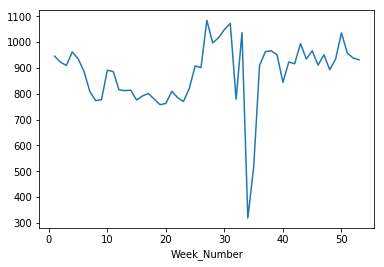

In [35]:
prd_grp=products_filtered.groupby('Week_Number')
prd_grp.mean().gmv.plot()

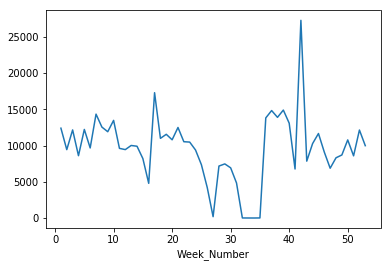

In [36]:
prd_grp=products_filtered.groupby('Week_Number')
prd_grp.count().order_id.plot()

{'whiskers': [<matplotlib.lines.Line2D at 0x297668ec5c0>,
 'caps': [<matplotlib.lines.Line2D at 0x297668eceb8>,
 'boxes': [<matplotlib.lines.Line2D at 0x297668ec470>],
 'medians': [<matplotlib.lines.Line2D at 0x297668d8748>],
 'fliers': [<matplotlib.lines.Line2D at 0x297668d8b70>],
 'means': []}

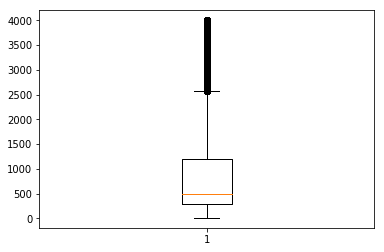

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.boxplot(products_filtered.gmv)

In [38]:
np.percentile(products_filtered.gmv,[5,10,20,50,70,80,90,95,99,100])

array([ 174.,  199.,  259.,  499.,  970., 1540., 2319., 2799., 3649.,
       3999.])

In [39]:
products_filtered.product_mrp.describe()

count    509512.000000
mean       1988.421649
std        3728.635695
min          63.000000
25%         699.000000
50%        1099.000000
75%        2000.000000
max       50000.000000
Name: product_mrp, dtype: float64

## 1.2 Understanding Media Investment

In [40]:
from pandas import ExcelWriter
from pandas import ExcelFile

media_invest = pd.read_excel('Media data and other information.xlsx', sheet_name='Media Investment',skiprows=2)

print(media_invest.columns)

Index(['Unnamed: 0', 'Year', 'Month', 'Total Investment', 'TV', 'Digital',
       'Sponsorship', 'Content Marketing', 'Online marketing', ' Affiliates',
       'SEM', 'Radio', 'Other'],
      dtype='object')


In [41]:
media_invest.head()

,Unnamed: 0,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
0,NaN,2015.0,7.0,17.061775,0.215330,2.533014,7.414270,0.000933,1.327278,0.547254,5.023697,NaN,NaN
1,NaN,2015.0,8.0,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,NaN,NaN
2,NaN,2015.0,9.0,96.254380,3.879504,1.356528,62.787651,0.610292,16.379990,5.038266,6.202149,NaN,NaN
3,NaN,2015.0,10.0,170.156297,6.144711,12.622480,84.672532,3.444075,24.371778,6.973711,31.927011,NaN,NaN
4,NaN,2015.0,11.0,51.216220,4.220630,1.275469,14.172116,0.168633,19.561574,6.595767,5.222032,NaN,NaN


In [42]:
#Dropping the Unnamed column
media_invest.drop(media_invest.columns[[0]],axis=1,inplace=True)

In [43]:
media_invest.head()

,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
0,2015.0,7.0,17.061775,0.215330,2.533014,7.414270,0.000933,1.327278,0.547254,5.023697,NaN,NaN
1,2015.0,8.0,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,NaN,NaN
2,2015.0,9.0,96.254380,3.879504,1.356528,62.787651,0.610292,16.379990,5.038266,6.202149,NaN,NaN
3,2015.0,10.0,170.156297,6.144711,12.622480,84.672532,3.444075,24.371778,6.973711,31.927011,NaN,NaN
4,2015.0,11.0,51.216220,4.220630,1.275469,14.172116,0.168633,19.561574,6.595767,5.222032,NaN,NaN


In [44]:
#Retaining only the rows corresponding to the 12 months from Jul2015 to Jun2016
media_invest.drop(media_invest[media_invest.index > 11].index,inplace=True)

In [45]:
#Replacing all the missing values with zeros
media_invest.fillna(0,inplace=True)

In [46]:
#Converting the year and month values to integer values from floating points
media_invest = media_invest.astype({"Year":'int64', "Month":'int64'}) 

In [47]:
#Trimming the columns of any white spaces
media_invest.columns = media_invest.columns.str.strip()

In [48]:
media_invest

,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
0,2015,7,17.061775,0.215330,2.533014,7.414270,0.000933,1.327278,0.547254,5.023697,0.00,0.000000
1,2015,8,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,0.00,0.000000
2,2015,9,96.254380,3.879504,1.356528,62.787651,0.610292,16.379990,5.038266,6.202149,0.00,0.000000
3,2015,10,170.156297,6.144711,12.622480,84.672532,3.444075,24.371778,6.973711,31.927011,0.00,0.000000
4,2015,11,51.216220,4.220630,1.275469,14.172116,0.168633,19.561574,6.595767,5.222032,0.00,0.000000
5,2015,12,106.745312,5.397502,3.063360,56.705419,1.067307,22.503756,6.826938,11.181030,0.00,0.000000
6,2016,1,74.196000,4.380000,0.456000,4.200000,0.900000,22.900000,7.370000,4.200000,2.70,27.090000
7,2016,2,48.052000,2.586008,1.912651,11.725555,0.596771,19.892366,6.465019,4.873630,0.00,0.000000
8,2016,3,100.024621,9.300000,2.100000,41.590000,0.370000,18.437818,6.217667,5.193591,0.87,15.945545
9,2016,4,56.848241,5.205196,0.871892,24.308354,0.034876,16.514510,5.693456,4.219958,0.00,0.000000


In [49]:
media_invest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 12 columns):
Year                 12 non-null int64
Month                12 non-null int64
Total Investment     12 non-null float64
TV                   12 non-null float64
Digital              12 non-null float64
Sponsorship          12 non-null float64
Content Marketing    12 non-null float64
Online marketing     12 non-null float64
Affiliates           12 non-null float64
SEM                  12 non-null float64
Radio                12 non-null float64
Other                12 non-null float64
dtypes: float64(10), int64(2)
memory usage: 1.2 KB


#### Observations:
- media_invest dataframe has 12 columns
- `Year` and `month` columns represent the year and month of investment
- The other 10 columns represent the monthly investments in 10 different advertising channels during the period Jul2015-Jun2016 



## 1.3 Understanding monthly NPS score

In [50]:
nps_score = pd.read_excel('Media data and other information.xlsx', sheet_name='Monthly NPS Score')
print(nps_score.columns)

Index(['Unnamed: 0', 'July'15', 'Aug'15', 'Sept'15', 'Oct'15', 'Nov'15',
       'Dec'15', 'Jan'16', 'Feb'16', 'Mar'16', 'Apr'16', 'May'16', 'June'16'],
      dtype='object')


In [51]:
nps_score = nps_score.T

In [52]:
nps_score.columns = ['NPS','Stock Index']

In [53]:
nps_score = nps_score.iloc[1:]

In [54]:
nps_score

,NPS,Stock Index
July'15,54.5996,1177
Aug'15,59.9871,1206
Sept'15,46.9254,1101
Oct'15,44.3984,1210
Nov'15,47,1233
Dec'15,45.8,1038
Jan'16,47.093,1052
Feb'16,50.3274,1222
Mar'16,49.0206,1015
Apr'16,51.8276,1242


In [55]:
nps_score.reset_index(level=0, inplace=True)

In [56]:
#Replacing the long month names with the shorter month names to help with the datetime parsing
nps_score = nps_score.replace('July', 'Jul', regex=True)
nps_score = nps_score.replace('Sept', 'Sep', regex=True)
nps_score = nps_score.replace('June', 'Jun', regex=True)

In [57]:
nps_score['MonthYear'] =  pd.to_datetime(nps_score['index'], format="%b'%y")

In [58]:
nps_score.drop(['index'],axis=1,inplace=True)

In [59]:
nps_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
NPS            12 non-null float64
Stock Index    12 non-null float64
MonthYear      12 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2)
memory usage: 368.0 bytes


In [60]:
nps_score

,NPS,Stock Index,MonthYear
0,54.599588,1177.0,2015-07-01
1,59.987101,1206.0,2015-08-01
2,46.925419,1101.0,2015-09-01
3,44.398389,1210.0,2015-10-01
4,47.000000,1233.0,2015-11-01
5,45.800000,1038.0,2015-12-01
6,47.093031,1052.0,2016-01-01
7,50.327406,1222.0,2016-02-01
8,49.020550,1015.0,2016-03-01
9,51.827605,1242.0,2016-04-01


#### Observations:
- nps_score dataframe has 3 columns
- `NPS` column represents the NPS score for the corresponding month value reprsented by `MonthYear` column
- `Stock Index` column represents the company stock price for the corresponding month value reprsented by `MonthYear` column

## 1.4 Understanding Special Sale Calendar

In [61]:
spl_sales = pd.read_excel('Media data and other information.xlsx', sheet_name='Special Sale Calendar')
spl_sales.columns

Index(['Unnamed: 0', 'Unnamed: 1', 'Sales Calendar'], dtype='object')

In [62]:
#Dropping the first column 
spl_sales.drop(['Unnamed: 0'],axis=1,inplace=True)

In [63]:
#Renaming the column to Year column as it contains year values
spl_sales.rename(columns={"Unnamed: 1": "Year"},inplace=True)

#Replacing all the missing values with zeros
spl_sales['Year'].fillna(0,inplace=True)

In [64]:
#Retaining only the rows corresponding to the special sale dates
spl_sales.drop(spl_sales[spl_sales.index > 11].index,inplace=True)

In [65]:
#Converting the year and month values to integer values from floating points
spl_sales = spl_sales.astype({"Year":'int64'}) 

In [66]:
#Filling up all the Year column values with the appropriate values
spl_sales.at[(spl_sales.index >= 1) & (spl_sales.index<=5),'Year']=2015
spl_sales.at[(spl_sales.index >= 7) & (spl_sales.index<=11),'Year']=2016

In [67]:
#Creating a column with the row index values
spl_sales['rowIndex'] = spl_sales.index

In [68]:
import datetime

#Custom function for extracting the start and end dates of the sale
def extractSaleDates(index, daterange):
    
    #Removing any trailing/leading white spaces
    datestr = daterange.strip()
    
    if(index != 5):
        
        if(index < 5):
            year=2015
        else:
            year=2016
    
        #Replacing 'th' with empty spaces
        datestr = datestr.replace("th","")
   
        #Splitting into day and month parts
        datestr = datestr.split(" ")
    
        days = datestr[0][1:].split("-")
        month = datestr[1][0:3]
    
        #Converting month name to a number
        monthNo = datetime.datetime.strptime(month, '%b').month
        startDay = int(days[0])
        endDay = int(days[1])
          
        startDate = datetime.datetime(year=year, month=monthNo, day=startDay)
        endDate = datetime.datetime(year=year, month=monthNo, day=endDay)
    
        if(startDate < endDate):    
            dateinfo = [startDate,endDate]
        else:
            dateinfo = [endDate,startDate]
            
    else:
        # Special case (25th Dec'15 - 3rd Jan'16)
        
        #Replacing 'th' with empty spaces
        datestr = datestr.replace("th","")
        datestr = datestr.replace("rd","")
        
        
        #Splitting the string into two parts
        datestr = datestr.split("-")
        startDatestr = datestr[0].replace(" ","")[1:]
        endDatestr = datestr[1].replace(" ","")[:-1]
        
        startDate = datetime.datetime.strptime(startDatestr, "%d%b'%y")
        endDate = datetime.datetime.strptime(endDatestr, "%d%b'%y")
        
        
        dateinfo = [startDate,endDate]
           
               
    return dateinfo
    

In [69]:
#Creating the "Start Date" and "End Date" columns to represent the start and end dates of the special sale window
spl_sales['Start Date'] = spl_sales.apply(lambda x: extractSaleDates(x['rowIndex'],x['Sales Calendar'])[0],axis=1)
spl_sales['End Date'] = spl_sales.apply(lambda x: extractSaleDates(x['rowIndex'],x['Sales Calendar'])[1],axis=1)

In [70]:
#Dropping the columns that are no longer required
spl_sales.drop(['rowIndex'],axis=1,inplace=True)
spl_sales.drop(['Year'],axis=1,inplace=True)
spl_sales.drop(['Sales Calendar'],axis=1,inplace=True)

In [71]:
spl_sales

,Start Date,End Date
0,2015-07-18,2015-07-19
1,2015-08-15,2015-08-17
2,2015-08-28,2015-08-30
3,2015-10-15,2015-10-17
4,2015-11-07,2015-11-14
5,2015-12-25,2016-01-03
6,2016-01-20,2016-01-22
7,2016-02-01,2016-02-02
8,2016-02-20,2016-02-21
9,2016-02-14,2016-02-15


#### Observations:
- `spl_sales` dataframe contains the special sale calendar between the period July 2015 - Jun 2016
- `spl_sales` dataframe contains two columns `Start Date` and `End Date` that contain the start and end dates for each special sale

## 1.5 Understanding Climate Data

In [72]:
#Creating climate data frame from the ONTARIO-20xx.xlsx

from pandas import ExcelWriter
from pandas import ExcelFile

climate2015 = pd.read_excel('ONTARIO-2015.xlsx', sheet_name='ONTARIO-2015',skiprows=24)
climate2016 = pd.read_excel('ONTARIO-2016.xlsx', sheet_name='ONTARIO-2016',skiprows=24)

In [73]:
climate2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 27 columns):
Date/Time                    365 non-null datetime64[ns]
Year                         365 non-null int64
Month                        365 non-null int64
Day                          365 non-null int64
Data Quality                 229 non-null object
Max Temp (°C)                216 non-null float64
Max Temp Flag                13 non-null object
Min Temp (°C)                190 non-null float64
Min Temp Flag                39 non-null object
Mean Temp (°C)               190 non-null float64
Mean Temp Flag               39 non-null object
Heat Deg Days (°C)           190 non-null float64
Heat Deg Days Flag           39 non-null object
Cool Deg Days (°C)           190 non-null float64
Cool Deg Days Flag           39 non-null object
Total Rain (mm)              229 non-null float64
Total Rain Flag              7 non-null object
Total Snow (cm)              229 non-null float64
Total Sn

In [74]:
climate2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 27 columns):
Date/Time                    366 non-null datetime64[ns]
Year                         366 non-null int64
Month                        366 non-null int64
Day                          366 non-null int64
Data Quality                 227 non-null object
Max Temp (°C)                226 non-null float64
Max Temp Flag                1 non-null object
Min Temp (°C)                219 non-null float64
Min Temp Flag                8 non-null object
Mean Temp (°C)               219 non-null float64
Mean Temp Flag               8 non-null object
Heat Deg Days (°C)           219 non-null float64
Heat Deg Days Flag           8 non-null object
Cool Deg Days (°C)           219 non-null float64
Cool Deg Days Flag           8 non-null object
Total Rain (mm)              227 non-null float64
Total Rain Flag              3 non-null object
Total Snow (cm)              227 non-null float64
Total Snow Fl

In [75]:
climate = climate2015.append(climate2016,ignore_index=True)

In [76]:
climate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 27 columns):
Date/Time                    731 non-null datetime64[ns]
Year                         731 non-null int64
Month                        731 non-null int64
Day                          731 non-null int64
Data Quality                 456 non-null object
Max Temp (°C)                442 non-null float64
Max Temp Flag                14 non-null object
Min Temp (°C)                409 non-null float64
Min Temp Flag                47 non-null object
Mean Temp (°C)               409 non-null float64
Mean Temp Flag               47 non-null object
Heat Deg Days (°C)           409 non-null float64
Heat Deg Days Flag           47 non-null object
Cool Deg Days (°C)           409 non-null float64
Cool Deg Days Flag           47 non-null object
Total Rain (mm)              456 non-null float64
Total Rain Flag              10 non-null object
Total Snow (cm)              456 non-null float64
Total S

In [77]:
#Retaining only the rows corresponding to the period July 2015 - Jun 2016
startDate = datetime.datetime(2015, 7, 1)
endDate = datetime.datetime(2016,6,30)
climate = climate[(climate['Date/Time'] >= startDate) & (climate['Date/Time'] <= endDate)] 
climate = climate.reset_index(drop=True)
climate.head()

,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,2015-07-01,2015,7,1,†,24.5,NaN,17.0,NaN,20.8,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,2015-07-02,2015,7,2,†,24.0,NaN,14.0,NaN,19.0,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,2015-07-03,2015,7,3,†,25.0,NaN,10.0,NaN,17.5,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,2015-07-04,2015,7,4,†,26.0,NaN,11.0,NaN,18.5,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,2015-07-05,2015,7,5,†,28.0,NaN,14.0,NaN,21.0,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [78]:
climate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 27 columns):
Date/Time                    366 non-null datetime64[ns]
Year                         366 non-null int64
Month                        366 non-null int64
Day                          366 non-null int64
Data Quality                 215 non-null object
Max Temp (°C)                208 non-null float64
Max Temp Flag                7 non-null object
Min Temp (°C)                191 non-null float64
Min Temp Flag                24 non-null object
Mean Temp (°C)               191 non-null float64
Mean Temp Flag               24 non-null object
Heat Deg Days (°C)           191 non-null float64
Heat Deg Days Flag           24 non-null object
Cool Deg Days (°C)           191 non-null float64
Cool Deg Days Flag           24 non-null object
Total Rain (mm)              215 non-null float64
Total Rain Flag              7 non-null object
Total Snow (cm)              215 non-null float64
Total Sno

In [79]:
#Dropping columns that have only null values
climate.drop(['Dir of Max Gust (10s deg)','Dir of Max Gust Flag','Spd of Max Gust (km/h)','Spd of Max Gust Flag'],axis=1,inplace=True)


In [80]:
climate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 23 columns):
Date/Time             366 non-null datetime64[ns]
Year                  366 non-null int64
Month                 366 non-null int64
Day                   366 non-null int64
Data Quality          215 non-null object
Max Temp (°C)         208 non-null float64
Max Temp Flag         7 non-null object
Min Temp (°C)         191 non-null float64
Min Temp Flag         24 non-null object
Mean Temp (°C)        191 non-null float64
Mean Temp Flag        24 non-null object
Heat Deg Days (°C)    191 non-null float64
Heat Deg Days Flag    24 non-null object
Cool Deg Days (°C)    191 non-null float64
Cool Deg Days Flag    24 non-null object
Total Rain (mm)       215 non-null float64
Total Rain Flag       7 non-null object
Total Snow (cm)       215 non-null float64
Total Snow Flag       6 non-null object
Total Precip (mm)     215 non-null float64
Total Precip Flag     11 non-null object
Snow on Grn

In [81]:
#Renaming the columns appropriately
climate.rename(columns={"Date/Time": "Date",
                        "Data Quality":"Data Quality Review"
                       },inplace=True)

In [82]:
climate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 23 columns):
Date                   366 non-null datetime64[ns]
Year                   366 non-null int64
Month                  366 non-null int64
Day                    366 non-null int64
Data Quality Review    215 non-null object
Max Temp (°C)          208 non-null float64
Max Temp Flag          7 non-null object
Min Temp (°C)          191 non-null float64
Min Temp Flag          24 non-null object
Mean Temp (°C)         191 non-null float64
Mean Temp Flag         24 non-null object
Heat Deg Days (°C)     191 non-null float64
Heat Deg Days Flag     24 non-null object
Cool Deg Days (°C)     191 non-null float64
Cool Deg Days Flag     24 non-null object
Total Rain (mm)        215 non-null float64
Total Rain Flag        7 non-null object
Total Snow (cm)        215 non-null float64
Total Snow Flag        6 non-null object
Total Precip (mm)      215 non-null float64
Total Precip Flag      11 non-nu

In [83]:
climate['Data Quality Review'].astype('category').value_counts(dropna=False)

†      215
NaN    151
Name: Data Quality Review, dtype: int64

In [84]:
climate['Data Quality Review'].replace(np.nan,"Yes",inplace=True)
climate['Data Quality Review'].replace('†',"No",inplace=True)
climate['Data Quality Review'].astype('category').value_counts(dropna=False)

No     215
Yes    151
Name: Data Quality Review, dtype: int64

In [85]:
climate['Max Temp (°C)'].describe()

count    208.000000
mean      19.177885
std        9.855212
min       -8.500000
25%       11.500000
50%       20.500000
75%       27.625000
max       35.000000
Name: Max Temp (°C), dtype: float64

In [86]:
climate['Max Temp Flag'].astype('category').value_counts(dropna=False)

NaN    359
M        7
Name: Max Temp Flag, dtype: int64

In [87]:
climate['Min Temp (°C)'].describe()

count    191.000000
mean       8.696335
std        8.757970
min      -18.000000
25%        2.750000
50%       10.000000
75%       16.000000
max       22.000000
Name: Min Temp (°C), dtype: float64

In [88]:
climate['Min Temp Flag'].astype('category').value_counts(dropna=False)

NaN    342
M       24
Name: Min Temp Flag, dtype: int64

In [89]:
climate['Mean Temp (°C)'].describe()

count    191.000000
mean      14.241361
std        8.941613
min      -12.300000
25%        8.000000
50%       15.300000
75%       21.800000
max       27.500000
Name: Mean Temp (°C), dtype: float64

In [90]:
climate['Mean Temp Flag'].astype('category').value_counts(dropna=False)

NaN    342
M       24
Name: Mean Temp Flag, dtype: int64

In [91]:
climate['Heat Deg Days (°C)'].describe()

count    191.000000
mean       5.712042
std        7.043183
min        0.000000
25%        0.000000
50%        2.700000
75%       10.000000
max       30.300000
Name: Heat Deg Days (°C), dtype: float64

In [92]:
climate['Heat Deg Days Flag'].astype('category').value_counts(dropna=False)

NaN    342
M       24
Name: Heat Deg Days Flag, dtype: int64

In [93]:
climate['Cool Deg Days (°C)'].describe()

count    191.000000
mean       1.953403
std        2.812954
min        0.000000
25%        0.000000
50%        0.000000
75%        3.800000
max        9.500000
Name: Cool Deg Days (°C), dtype: float64

In [94]:
climate['Cool Deg Days Flag'].astype('category').value_counts(dropna=False)

NaN    342
M       24
Name: Cool Deg Days Flag, dtype: int64

In [95]:
climate['Total Rain (mm)'].describe()

count    215.000000
mean       2.583721
std        6.684405
min        0.000000
25%        0.000000
50%        0.000000
75%        1.400000
max       57.200000
Name: Total Rain (mm), dtype: float64

In [96]:
climate['Total Rain Flag'].astype('category').value_counts(dropna=False)

NaN    359
T        7
Name: Total Rain Flag, dtype: int64

In [97]:
climate['Total Snow (cm)'].describe()

count    215.000000
mean       0.204651
std        1.132104
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       10.000000
Name: Total Snow (cm), dtype: float64

In [98]:
climate['Total Snow Flag'].astype('category').value_counts(dropna=False)

NaN    360
T        6
Name: Total Snow Flag, dtype: int64

In [99]:
climate['Total Precip (mm)'].describe()

count    215.000000
mean       2.788372
std        6.827481
min        0.000000
25%        0.000000
50%        0.000000
75%        2.100000
max       57.200000
Name: Total Precip (mm), dtype: float64

In [100]:
climate['Total Precip Flag'].astype('category').value_counts(dropna=False)

NaN    355
T       11
Name: Total Precip Flag, dtype: int64

In [101]:
climate['Snow on Grnd (cm)'].describe()

count    215.000000
mean       0.288372
std        1.497850
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       12.000000
Name: Snow on Grnd (cm), dtype: float64

In [102]:
climate['Snow on Grnd Flag'].astype('category').value_counts(dropna=False)

NaN    360
T        6
Name: Snow on Grnd Flag, dtype: int64

# Phase 2: Data Preparation

## 2.1 Data preparation for order level data

In [103]:
products_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 509512 entries, 2 to 1647171
Data columns (total 20 columns):
fsn_id                             509512 non-null object
order_date                         509512 non-null datetime64[ns]
Year                               509512 non-null int64
Month                              509512 non-null int64
order_id                           509512 non-null int64
order_item_id                      509512 non-null int64
gmv                                509512 non-null float64
units                              509512 non-null int64
s1_fact.order_payment_type         509512 non-null object
sla                                509512 non-null int64
cust_id                            509512 non-null float64
pincode                            509512 non-null float64
product_analytic_super_category    509512 non-null object
product_analytic_category          509512 non-null object
product_analytic_sub_category      509512 non-null object
product_analy

#### Observation
- There are 509512 data points and all the null values and outliers are handled

## 2.2 Data preparation for media investment

In [104]:
media_invest

,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
0,2015,7,17.061775,0.215330,2.533014,7.414270,0.000933,1.327278,0.547254,5.023697,0.00,0.000000
1,2015,8,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,0.00,0.000000
2,2015,9,96.254380,3.879504,1.356528,62.787651,0.610292,16.379990,5.038266,6.202149,0.00,0.000000
3,2015,10,170.156297,6.144711,12.622480,84.672532,3.444075,24.371778,6.973711,31.927011,0.00,0.000000
4,2015,11,51.216220,4.220630,1.275469,14.172116,0.168633,19.561574,6.595767,5.222032,0.00,0.000000
5,2015,12,106.745312,5.397502,3.063360,56.705419,1.067307,22.503756,6.826938,11.181030,0.00,0.000000
6,2016,1,74.196000,4.380000,0.456000,4.200000,0.900000,22.900000,7.370000,4.200000,2.70,27.090000
7,2016,2,48.052000,2.586008,1.912651,11.725555,0.596771,19.892366,6.465019,4.873630,0.00,0.000000
8,2016,3,100.024621,9.300000,2.100000,41.590000,0.370000,18.437818,6.217667,5.193591,0.87,15.945545
9,2016,4,56.848241,5.205196,0.871892,24.308354,0.034876,16.514510,5.693456,4.219958,0.00,0.000000


In [105]:
media_invest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 12 columns):
Year                 12 non-null int64
Month                12 non-null int64
Total Investment     12 non-null float64
TV                   12 non-null float64
Digital              12 non-null float64
Sponsorship          12 non-null float64
Content Marketing    12 non-null float64
Online marketing     12 non-null float64
Affiliates           12 non-null float64
SEM                  12 non-null float64
Radio                12 non-null float64
Other                12 non-null float64
dtypes: float64(10), int64(2)
memory usage: 1.2 KB


#### Observations:
- There are no missing values

## 2.3 Data preparation for special sale calendar & pay day

In [106]:
spl_sales

,Start Date,End Date
0,2015-07-18,2015-07-19
1,2015-08-15,2015-08-17
2,2015-08-28,2015-08-30
3,2015-10-15,2015-10-17
4,2015-11-07,2015-11-14
5,2015-12-25,2016-01-03
6,2016-01-20,2016-01-22
7,2016-02-01,2016-02-02
8,2016-02-20,2016-02-21
9,2016-02-14,2016-02-15


#### Observations:
- spl_sales dataframe contains the special sale calendar between the period July 2015 - Jun 2016
- spl_sales dataframe contains two columns Start Date and End Date that contain the start and end dates for each special sale
- Data does not containing any missing values

In [107]:
#Creating a data frame for storing special sales and pay day info at a daily level
startDate = datetime.datetime(2015, 7, 1)
endDate = datetime.datetime(2016,6,30)

column_names = ["Week_Number","order_date", "Is Special Sale","Is Pay Day"]
sales_pay_daily_info = pd.DataFrame(columns = column_names)

i = startDate
while (i <= endDate):

    isSpecialSale = 0
    isPayDay = 0

    for ind in spl_sales.index:
        if (i >= spl_sales['Start Date'][ind] and i <= spl_sales['End Date'][ind] ):
            isSpecialSale = 1
            break
    
    
    if(i.day == 1 or i.day == 15):
        isPayDay = 1
    
    sales_pay_daily_info = sales_pay_daily_info.append({'Week_Number': i.isocalendar()[1],
                                                         'order_date' : i , 
                                                         'Is Special Sale' : isSpecialSale,
                                                         'Is Pay Day': isPayDay
                                                       },
                                                       ignore_index=True)
    
    i += datetime.timedelta(days=1)   

In [108]:
sales_pay_daily_info.head()

,Week_Number,order_date,Is Special Sale,Is Pay Day
0,27,2015-07-01,0,1
1,27,2015-07-02,0,0
2,27,2015-07-03,0,0
3,27,2015-07-04,0,0
4,27,2015-07-05,0,0


In [109]:
#Grouping the data frame by the week number
sales_pay_info_by_week = sales_pay_daily_info.groupby(['Week_Number'])

In [110]:
#Calculating the no. of special sale days and pay days in each week
sspc_week = pd.DataFrame(sales_pay_info_by_week.agg({'Is Special Sale':['sum'],'Is Pay Day':['sum']}).reset_index())

In [111]:
sspc_week.columns = ['Week_Number','Special Sale Day Count','Pay Day Count']

In [112]:
# Dataframe containing the no. of special sale days in each of the 53 weeks
sspc_week.head()

,Week_Number,Special Sale Day Count,Pay Day Count
0,1,0,0
1,2,0,1
2,3,3,0
3,4,0,0
4,5,2,1


## 2.4 Data preparation for monthly NPS score

In [113]:
nps_score

,NPS,Stock Index,MonthYear
0,54.599588,1177.0,2015-07-01
1,59.987101,1206.0,2015-08-01
2,46.925419,1101.0,2015-09-01
3,44.398389,1210.0,2015-10-01
4,47.000000,1233.0,2015-11-01
5,45.800000,1038.0,2015-12-01
6,47.093031,1052.0,2016-01-01
7,50.327406,1222.0,2016-02-01
8,49.020550,1015.0,2016-03-01
9,51.827605,1242.0,2016-04-01


#### Observations:

- nps_score dataframe has 3 columns
- NPS column represents the NPS score for the corresponding month value reprsented by MonthYear column
- Stock Index column represents the company stock price for the corresponding month value reprsented by MonthYear column

In [114]:
#Creating a data frame for storing nps and stock price values at a daily level
startDate = datetime.datetime(2015, 7, 1)
endDate = datetime.datetime(2016,6,30)

column_names = ["Week_Number","order_date", "NPS","Stock Index"]
nps_daily_info = pd.DataFrame(columns = column_names)

i = startDate
while (i <= endDate):


    for ind in nps_score.index:
        if (i.month == nps_score['MonthYear'][ind].month):
            nps_daily_info = nps_daily_info.append({'Week_Number': i.isocalendar()[1],
                                                    'order_date' : i, 
                                                    'NPS' : nps_score['NPS'][ind],
                                                    'Stock Index': nps_score['Stock Index'][ind]
                                                    },
                                                   ignore_index=True)
            break
    
    i += datetime.timedelta(days=1)   

In [115]:
nps_daily_info.head()

,Week_Number,order_date,NPS,Stock Index
0,27,2015-07-01,54.599588,1177.0
1,27,2015-07-02,54.599588,1177.0
2,27,2015-07-03,54.599588,1177.0
3,27,2015-07-04,54.599588,1177.0
4,27,2015-07-05,54.599588,1177.0


In [116]:
#Grouping the data frame by the week number
nps_info_by_week = nps_daily_info.groupby(['Week_Number'])

In [117]:
#Calculating the no. of special sale days and pay days in each week
nps_week = pd.DataFrame(nps_info_by_week.agg({'NPS':['mean'],'Stock Index':['mean']}).reset_index())

In [118]:
nps_week.columns = ['Week_Number','NPS','Stock Index']

In [119]:
# Dataframe containing the NPS and Stock Index values to be used for each of the 53 weeks
nps_week.head()

,Week_Number,NPS,Stock Index
0,1,47.093031,1052.0
1,2,47.093031,1052.0
2,3,47.093031,1052.0
3,4,47.093031,1052.0
4,5,50.327406,1222.0


## 2.5 Data preparation for climate data

In [120]:
climate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 23 columns):
Date                   366 non-null datetime64[ns]
Year                   366 non-null int64
Month                  366 non-null int64
Day                    366 non-null int64
Data Quality Review    366 non-null object
Max Temp (°C)          208 non-null float64
Max Temp Flag          7 non-null object
Min Temp (°C)          191 non-null float64
Min Temp Flag          24 non-null object
Mean Temp (°C)         191 non-null float64
Mean Temp Flag         24 non-null object
Heat Deg Days (°C)     191 non-null float64
Heat Deg Days Flag     24 non-null object
Cool Deg Days (°C)     191 non-null float64
Cool Deg Days Flag     24 non-null object
Total Rain (mm)        215 non-null float64
Total Rain Flag        7 non-null object
Total Snow (cm)        215 non-null float64
Total Snow Flag        6 non-null object
Total Precip (mm)      215 non-null float64
Total Precip Flag      11 non-nu

In [121]:
climate.head()

,Date,Year,Month,Day,Data Quality Review,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),...,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag
0,2015-07-01,2015,7,1,No,24.5,NaN,17.0,NaN,20.8,...,2.8,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
1,2015-07-02,2015,7,2,No,24.0,NaN,14.0,NaN,19.0,...,1.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
2,2015-07-03,2015,7,3,No,25.0,NaN,10.0,NaN,17.5,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
3,2015-07-04,2015,7,4,No,26.0,NaN,11.0,NaN,18.5,...,0.5,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
4,2015-07-05,2015,7,5,No,28.0,NaN,14.0,NaN,21.0,...,3.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN


# Phase 3: Exploratory Data Analysis

## 3.1 Percentage revenue share of product subcategories
- What is the % revenue share contribution of the 3 product subcategories  camera accessory, home audio and gaming accessory ? 
- What about the other sub-categories?


In [122]:
#Grouping the data by the product sub-category 
products_by_subcatg = products.groupby(['product_analytic_sub_category'])

#Calculating the gross product revenue per sub-category
gross_revenue_per_subcatg = products_by_subcatg.agg({'gmv':'sum'}).reset_index()

#Calculating the % Revenue share of each product sub-category
gross_revenue_per_subcatg['% Revenue'] = round(100*gross_revenue_per_subcatg['gmv']/products.gmv.sum(),2)

#Sorting the product sub-categories in descending order of gross revenue
gross_revenue_per_subcatg.sort_values("% Revenue", axis = 0, ascending = False,inplace = True) 

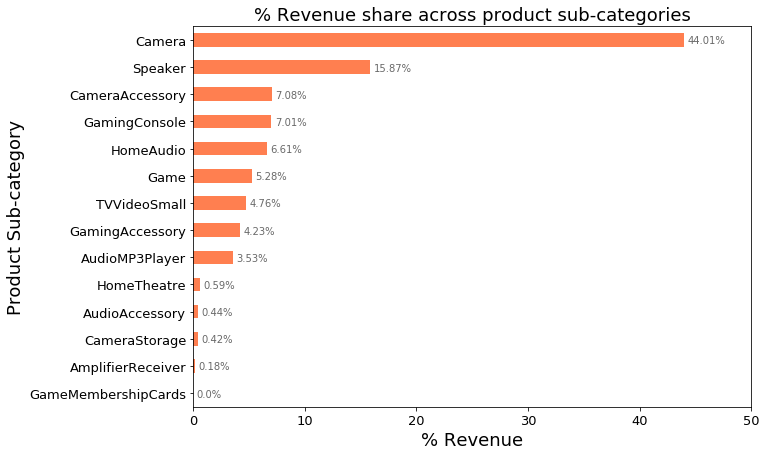

In [123]:
#Plotting the gross product revenue across all product subcategories
ax = gross_revenue_per_subcatg.plot(x='product_analytic_sub_category',
                                    y='% Revenue', 
                                    kind='barh', 
                                    figsize=(10,7),
                                    legend=None,
                                    color="coral", fontsize=13);

ax.set_alpha(0.8)
ax.set_title("% Revenue share across product sub-categories", fontsize=18)
ax.set_xlabel("% Revenue", fontsize=18);
ax.set_ylabel("Product Sub-category", fontsize=18);
ax.set_xticks([0, 10, 20, 30, 40, 50])

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.38, str(round((i.get_width()/total)*100, 2))+'%', fontsize=10,color='dimgrey')

# invert for largest on top 
ax.invert_yaxis()

## 3.2 Product revenue across time


In [124]:
#Grouping the data by week 
products_by_week_subcatg = products_filtered.groupby(['Week_Number','product_analytic_sub_category'])
products_by_week = products_filtered.groupby(['Week_Number'])

#Calculating the gross product revenue per week
gross_revenue_by_week_subcatg = products_by_week_subcatg.agg({'gmv':'sum'}).reset_index()
gross_revenue_by_week = products_by_week.agg({'gmv':'sum'}).reset_index()



Text(0,0.5,'Gross weekly revenue')

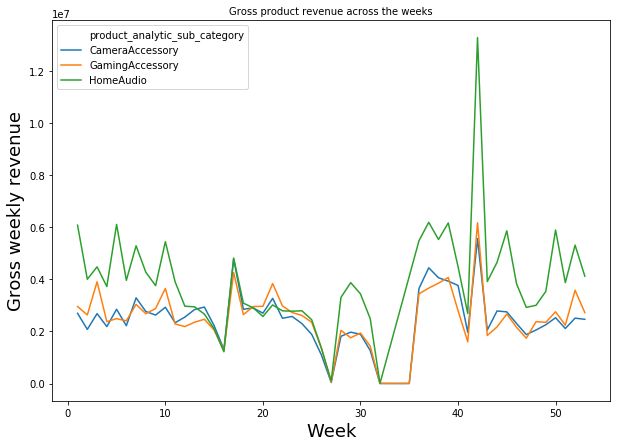

In [125]:
plt.figure(figsize=(10, 7))
x = sns.lineplot(x="Week_Number", y="gmv",hue='product_analytic_sub_category',data=gross_revenue_by_week_subcatg)
x.set_title("Gross product revenue across the weeks", fontsize=10)
x.set_xlabel("Week", fontsize=18);
x.set_ylabel("Gross weekly revenue", fontsize=18)

Text(0,0.5,'Gross weekly revenue')

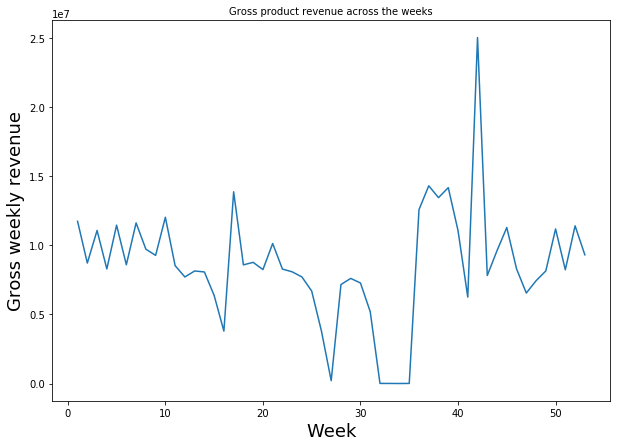

In [126]:
plt.figure(figsize=(10, 7))
x = sns.lineplot(x="Week_Number", y="gmv",data=gross_revenue_by_week)
x.set_title("Gross product revenue across the weeks", fontsize=10)
x.set_xlabel("Week", fontsize=18);
x.set_ylabel("Gross weekly revenue", fontsize=18)

## 3.3 Complementary Products
- Identifying products that are sold along with other products

### Reusable Methods

In [127]:

#Method for calculating the complementary measure of a product
def calculateProdCompMeasure(df):
    
    orderdata = df[['order_id','order_item_id','product_analytic_vertical']]
    
    #Grouping the order data by the order_id
    odata_by_orderid = orderdata.groupby("order_id")
    
    #Finding the unique list of products
    products = orderdata.product_analytic_vertical.unique().tolist()
    
    #Finding the unique list of order_ids
    order_ids = orderdata.order_id.unique().tolist()
    
    comp_product_group = []
    i = 0

    #Iterating through the list of order ids to find the list of products that are bought together in a sinle order
    for id in order_ids:
        
        productList = odata_by_orderid.get_group(id)['product_analytic_vertical'].tolist()
        productList = list(dict.fromkeys(productList))

        if(len(productList) > 1):
            print("Index " + str(i))
            comp_product_group.append(productList)

        i = i + 1
    
    #Creating a product matrix to store frequency count of how often any two products are bought together
    product_count = len(products)
    product_matrix = np.matrix(np.zeros((product_count,product_count),np.int64))
    
    # Calculating the frequency of how often any two products appear in the same order
    for i,product1 in enumerate(products):
        for j,product2 in enumerate(products):
            if (i != j):
                for plist in comp_product_group:
                    if(product1 in plist and product2 in plist):
                        product_matrix[i,j] = product_matrix[i,j] + 1  
    
    
    #Calculating the total occurences when a product is bought along with other products
    product_measure = product_matrix.sum(axis=1)
    
    #Converting the results into a data frame
    
    prod_comp_measure = pd.DataFrame(columns=['Product','Measure'])
    
    for i,name in enumerate(products):
        prod_comp_measure = prod_comp_measure.append({'Product':name,'Measure':product_measure.item(i)},ignore_index=True)
    
    prod_comp_measure['Measure'] = prod_comp_measure['Measure']/prod_comp_measure.Measure.sum()
    
    return prod_comp_measure
    

In [128]:
orderdata_CA=pd.DataFrame(products_filtered[products_filtered.product_analytic_sub_category.isin(['CameraAccessory'])])
prod_comp_measure_CA=calculateProdCompMeasure(orderdata_CA)

Index 1
Index 3
Index 9
Index 19
Index 40
Index 49
Index 91
Index 134
Index 141
Index 142
Index 206
Index 212
Index 236
Index 250
Index 288
Index 300
Index 333
Index 343
Index 365
Index 368
Index 448
Index 450
Index 463
Index 478
Index 482
Index 486
Index 511
Index 516
Index 517
Index 523
Index 561
Index 564
Index 568
Index 570
Index 572
Index 633
Index 713
Index 729
Index 731
Index 732
Index 744
Index 747
Index 751
Index 763
Index 783
Index 803
Index 806
Index 838
Index 844
Index 848
Index 866
Index 869
Index 879
Index 887
Index 900
Index 903
Index 924
Index 927
Index 930
Index 954
Index 975
Index 1002
Index 1005
Index 1015
Index 1019
Index 1023
Index 1048
Index 1051
Index 1055
Index 1056
Index 1057
Index 1058
Index 1059
Index 1070
Index 1100
Index 1119
Index 1146
Index 1165
Index 1172
Index 1178
Index 1179
Index 1183
Index 1187
Index 1201
Index 1208
Index 1209
Index 1227
Index 1245
Index 1250
Index 1251
Index 1252
Index 1269
Index 1279
Index 1329
Index 1346
Index 1349
Index 1353
Inde

Index 25381
Index 25420
Index 25486
Index 25775
Index 25781
Index 25791
Index 25861
Index 25874
Index 25881
Index 25886
Index 25898
Index 25904
Index 25945
Index 25948
Index 25952
Index 25956
Index 25959
Index 26012
Index 26018
Index 26264
Index 26317
Index 26320
Index 26322
Index 26324
Index 26353
Index 26452
Index 26571
Index 26581
Index 26584
Index 26590
Index 26602
Index 26605
Index 26616
Index 26625
Index 26661
Index 26664
Index 26746
Index 26752
Index 26797
Index 26808
Index 26815
Index 26816
Index 26818
Index 26819
Index 26821
Index 26822
Index 26823
Index 26824
Index 26825
Index 26826
Index 26827
Index 26830
Index 26838
Index 26849
Index 26852
Index 26896
Index 26927
Index 26959
Index 26970
Index 27143
Index 27203
Index 27216
Index 27224
Index 27229
Index 27241
Index 27249
Index 27298
Index 27305
Index 27375
Index 28018
Index 28136
Index 28165
Index 28172
Index 28174
Index 28186
Index 28193
Index 28205
Index 28408
Index 28452
Index 29720
Index 29847
Index 30260
Index 30274
Inde

Index 56498
Index 56706
Index 56740
Index 56753
Index 56763
Index 56769
Index 56776
Index 56794
Index 56838
Index 56932
Index 56954
Index 56979
Index 57032
Index 57042
Index 57048
Index 57327
Index 57514
Index 57519
Index 58180
Index 58287
Index 58635
Index 58728
Index 58764
Index 59620
Index 62831
Index 63093
Index 63098
Index 63099
Index 63309
Index 63329
Index 63397
Index 63407
Index 63425
Index 63905
Index 63913
Index 64074
Index 64403
Index 66384
Index 66431
Index 66567
Index 66666
Index 66813
Index 66839
Index 66840
Index 66873
Index 66877
Index 67796
Index 67813
Index 67831
Index 67834
Index 67850
Index 67864
Index 67885
Index 67893
Index 67899
Index 67921
Index 67928
Index 67930
Index 67931
Index 68039
Index 68044
Index 68066
Index 68072
Index 68077
Index 68088
Index 68105
Index 68110
Index 68114
Index 68130
Index 68157
Index 68169
Index 68170
Index 68175
Index 68226
Index 68276
Index 68278
Index 68286
Index 68287
Index 68299
Index 68304
Index 68312
Index 68313
Index 68322
Inde

Index 97383
Index 97566
Index 97736
Index 97739
Index 97757
Index 97773
Index 98184
Index 98185
Index 98219
Index 98409
Index 98462
Index 98661
Index 98686
Index 98699
Index 99131
Index 100587
Index 100639
Index 100640
Index 100784
Index 100800
Index 100803
Index 100925
Index 101206
Index 101312
Index 102414
Index 103594
Index 103748
Index 103848
Index 103867
Index 103869
Index 104000
Index 104003
Index 104157
Index 104242
Index 104285
Index 104294
Index 104328
Index 104338
Index 104349
Index 104357
Index 104373
Index 104377
Index 104382
Index 104585
Index 104655
Index 104704
Index 105510
Index 105559
Index 105602
Index 105714
Index 105743
Index 105751
Index 105764
Index 105770
Index 105778
Index 105983
Index 105985
Index 106097
Index 106345
Index 106367
Index 106407
Index 106474
Index 106489
Index 106490
Index 106500
Index 106515
Index 106517
Index 106540
Index 106562
Index 106608
Index 106613
Index 106628
Index 106636
Index 106645
Index 106648
Index 106661
Index 106668
Index 106670
I

Index 133747
Index 133748
Index 133750
Index 133753
Index 133760
Index 133762
Index 133765
Index 133768
Index 133771
Index 133773
Index 133777
Index 133812
Index 133958
Index 133967
Index 133988
Index 134018
Index 134022
Index 134046
Index 134056
Index 134057
Index 134058
Index 134066
Index 134076
Index 134080
Index 134083
Index 134094
Index 134096
Index 134099
Index 134128
Index 134140
Index 134158
Index 134163
Index 134174
Index 134180
Index 134197
Index 134246
Index 134263
Index 134275
Index 134344
Index 134362
Index 134366
Index 134384
Index 134422
Index 134424
Index 134437
Index 134445
Index 134505
Index 134507
Index 134512
Index 134547
Index 134563
Index 134566
Index 134585
Index 134620
Index 134628
Index 134649
Index 134652
Index 134654
Index 134663
Index 134677
Index 134722
Index 134727
Index 134739
Index 134774
Index 134777
Index 134787
Index 134789
Index 134804
Index 134806
Index 134809
Index 134814
Index 134816
Index 134824
Index 134827
Index 134829
Index 134830
Index 134831

Index 181604
Index 181649
Index 181653
Index 181654
Index 181661
Index 181691
Index 181702
Index 181726
Index 181740
Index 181741
Index 181749
Index 181751
Index 181836
Index 181840
Index 181857
Index 181874
Index 181999
Index 182003
Index 182010
Index 182016
Index 182048
Index 182101
Index 182162
Index 182214
Index 182240
Index 182242
Index 182261
Index 182266
Index 182278
Index 182282
Index 182291
Index 182295
Index 182298
Index 182301
Index 182302
Index 182305
Index 182308
Index 182309
Index 182310
Index 182311
Index 182312
Index 182313
Index 182316
Index 182356
Index 182357
Index 182358
Index 182371
Index 182416
Index 182421
Index 182428
Index 182442
Index 182451
Index 182457
Index 182459
Index 182460
Index 182462
Index 182463
Index 182491
Index 182533
Index 182617
Index 182624
Index 182641
Index 182643
Index 182680
Index 182691
Index 182699
Index 182717
Index 182744
Index 182746
Index 182771
Index 182784
Index 182791
Index 182806
Index 182823
Index 182838
Index 182843
Index 182846

In [129]:
orderdata_HA=pd.DataFrame(products_filtered[products_filtered.product_analytic_sub_category.isin(['HomeAudio'])])
prod_comp_measure_HA = calculateProdCompMeasure(orderdata_HA)

Index 2354
Index 5203
Index 5935
Index 20169
Index 32056
Index 35289
Index 36431
Index 43181
Index 53651
Index 55349
Index 94089
Index 94577
Index 94601
Index 95134
Index 95156
Index 96826
Index 97527


In [130]:
orderdata_GA=pd.DataFrame(products_filtered[products_filtered.product_analytic_sub_category.isin(['GamingAccessory'])])
prod_comp_measure_GA = calculateProdCompMeasure(orderdata_GA)

Index 52
Index 235
Index 296
Index 302
Index 340
Index 460
Index 466
Index 478
Index 486
Index 492
Index 501
Index 508
Index 548
Index 607
Index 608
Index 626
Index 650
Index 781
Index 798
Index 867
Index 1466
Index 2255
Index 2302
Index 2307
Index 2414
Index 2418
Index 2456
Index 2582
Index 2641
Index 3150
Index 3256
Index 3316
Index 3401
Index 3423
Index 3430
Index 3481
Index 3787
Index 3836
Index 3837
Index 3856
Index 3861
Index 3864
Index 3872
Index 3873
Index 3878
Index 3880
Index 3883
Index 3885
Index 3896
Index 3918
Index 3921
Index 3958
Index 3961
Index 3970
Index 3971
Index 3978
Index 3984
Index 3989
Index 3990
Index 3993
Index 4016
Index 4018
Index 4020
Index 4032
Index 4033
Index 4056
Index 4057
Index 4067
Index 4068
Index 4071
Index 4086
Index 4090
Index 4101
Index 4123
Index 4124
Index 4131
Index 4141
Index 4142
Index 4143
Index 4157
Index 4161
Index 4168
Index 4170
Index 4172
Index 4174
Index 4177
Index 4198
Index 4200
Index 4230
Index 4234
Index 4242
Index 4299
Index 433

Index 104283
Index 104453
Index 104454
Index 104460
Index 104534
Index 104537
Index 104609
Index 104610
Index 104619
Index 104643
Index 104661
Index 104665
Index 104705
Index 104767
Index 104867
Index 104881
Index 104882
Index 104888
Index 104900
Index 104908
Index 104910
Index 104938
Index 104952
Index 105103
Index 105114
Index 105147
Index 105151
Index 105279
Index 105323
Index 105386
Index 105415
Index 105696
Index 105783
Index 105851
Index 105904
Index 105935
Index 105936
Index 105938
Index 105958
Index 106048
Index 106087
Index 106089
Index 106119
Index 106167
Index 106190
Index 106191
Index 106212
Index 106215
Index 106219
Index 106525
Index 106575
Index 106659
Index 106859
Index 106904
Index 106927
Index 107463
Index 107519
Index 108137
Index 108141
Index 108163
Index 108167
Index 108207
Index 108216
Index 108245
Index 108548
Index 108604
Index 108610
Index 108612
Index 109547
Index 109594
Index 109791
Index 109844
Index 110598
Index 110945
Index 111175
Index 111615
Index 111629

In [131]:
prod_comp_measure_CA.sort_values('Measure',ascending=False)

,Product,Measure
4,Lens,0.218613
2,CameraBattery,0.19237
6,Filter,0.180578
3,CameraBatteryCharger,0.166127
1,CameraBag,0.0621965
0,CameraTripod,0.0558382
5,CameraRemoteControl,0.0552601
9,Flash,0.0292486
8,Strap,0.0179191
11,CameraAccessory,0.00809249


In [132]:
prod_comp_measure_HA.sort_values('Measure',ascending=False)

,Product,Measure
4,FMRadio,0.411765
0,HomeAudioSpeaker,0.382353
2,BoomBox,0.117647
6,VoiceRecorder,0.0588235
1,Dock,0.0294118
3,DockingStation,0
5,HiFiSystem,0
7,DJController,0
8,SoundMixer,0


In [133]:
prod_comp_measure_GA.sort_values('Measure',ascending=False)

,Product,Measure
3,GamingMouse,0.286697
0,GamePad,0.177752
10,GamingKeyboard,0.173547
8,GamingMousePad,0.127294
1,GamingAccessoryKit,0.110856
9,GamingHeadset,0.0588685
2,MotionController,0.0187309
5,TVOutCableAccessory,0.0141437
6,JoystickGamingWheel,0.0103211
7,GamingMemoryCard,0.00993884


#### Observations:
- Complementary Product Measure (CPM) is a measure of how much a product is sold along with other products
- Computer Accessory sub-category: Lens product has the highest CPM (0.21)
- Gaming Accessory sub-category: GamingMouse product has the highest CPM (0.28)
- Home Audio sub-category: FMRadio product has the highest CPM (0.41)
- Computer Accessory sub-category: CameraLEDLight, CameraMicrophone, FlashShoeAdapter, ReflectorUmbrella & CameraHousing have 0 CPM indicating that there were not sold with any other products
- Gaming Accessory sub-category: GameControlMount have 0 CPM indicating that there were not sold with any other products
- Home Audio sub-category: DockingStation, HiFiSystem, DJController & SoundMixer have 0 CPM indicating that there were not sold with any other products


## 3.3 Products correlated to Pay Day (1st or 15th of month)

In [134]:
proddata_CA=pd.DataFrame(products_filtered[products_filtered.product_analytic_sub_category.isin(['CameraAccessory'])])
proddata_GA=pd.DataFrame(products_filtered[products_filtered.product_analytic_sub_category.isin(['GamingAccessory'])])
proddata_HA=pd.DataFrame(products_filtered[products_filtered.product_analytic_sub_category.isin(['HomeAudio'])])

In [135]:
CA_proddata_by_day = proddata_CA.groupby(["order_date"])
GA_proddata_by_day = proddata_GA.groupby(["order_date"])
HA_proddata_by_day = proddata_HA.groupby(["order_date"])

In [136]:
total_units_by_day_CA = CA_proddata_by_day.agg({'units':'sum'}).reset_index()
total_units_by_day_GA = GA_proddata_by_day.agg({'units':'sum'}).reset_index()
total_units_by_day_HA = HA_proddata_by_day.agg({'units':'sum'}).reset_index()

In [137]:
total_units_by_day_CA['Pay Day'] = np.where((total_units_by_day_CA['order_date'].dt.day == 1) | 
                                            (total_units_by_day_CA['order_date'].dt.day == 15) ,
                                            100, 0)

total_units_by_day_GA['Pay Day'] = np.where((total_units_by_day_GA['order_date'].dt.day == 1) | 
                                            (total_units_by_day_GA['order_date'].dt.day == 15) ,
                                            100, 0)

total_units_by_day_HA['Pay Day'] = np.where((total_units_by_day_HA['order_date'].dt.day == 1) | 
                                            (total_units_by_day_HA['order_date'].dt.day == 15) ,
                                            100, 0)

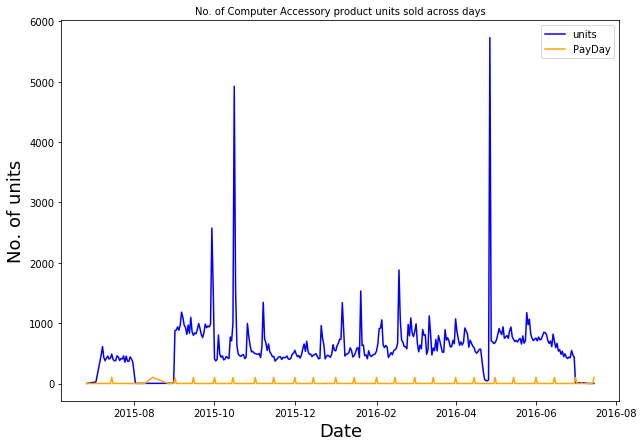

In [138]:
fig, ax = plt.subplots(figsize=(10,7))
sns.lineplot(x="order_date", y="units",data=total_units_by_day_CA,color='blue',ax=ax)
sns.lineplot(x="order_date", y="Pay Day",data=total_units_by_day_CA,color='orange',ax=ax)

ax.legend(['units', 'PayDay'], facecolor='w')
ax.set_title("No. of Computer Accessory product units sold across days", fontsize=10)
ax.set_xlabel("Date", fontsize=18);
ax.set_ylabel("No. of units", fontsize=18)

plt.show()

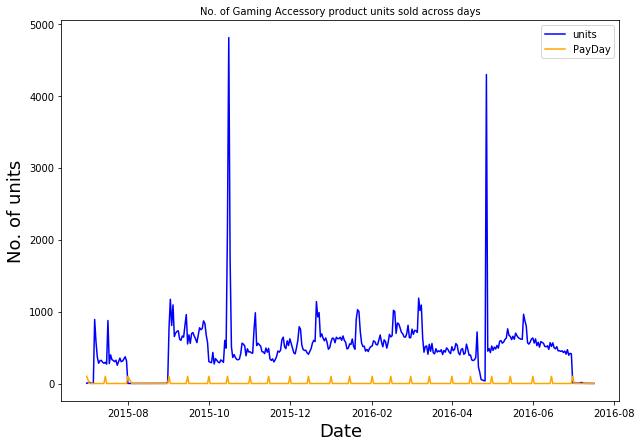

In [139]:
fig, ax = plt.subplots(figsize=(10,7))
sns.lineplot(x="order_date", y="units",data=total_units_by_day_GA,color='blue',ax=ax)
sns.lineplot(x="order_date", y="Pay Day",data=total_units_by_day_GA,color='orange',ax=ax)

ax.legend(['units', 'PayDay'], facecolor='w')
ax.set_title("No. of Gaming Accessory product units sold across days", fontsize=10)
ax.set_xlabel("Date", fontsize=18);
ax.set_ylabel("No. of units", fontsize=18)

plt.show()

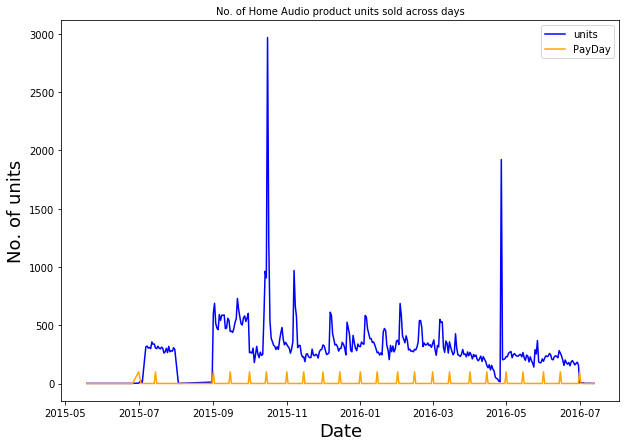

In [140]:
fig, ax = plt.subplots(figsize=(10,7))
sns.lineplot(x="order_date", y="units",data=total_units_by_day_HA,color='blue',ax=ax)
sns.lineplot(x="order_date", y="Pay Day",data=total_units_by_day_HA,color='orange',ax=ax)

ax.legend(['units', 'PayDay'], facecolor='w')
ax.set_title("No. of Home Audio product units sold across days", fontsize=10)
ax.set_xlabel("Date", fontsize=18);
ax.set_ylabel("No. of units", fontsize=18)

plt.show()

## 3.4 Procurement & Delivery SLA

In [141]:
#Product subcategory: Computer Accessory
proddata_CA=pd.DataFrame(products_filtered[products_filtered.product_analytic_sub_category.isin(['CameraAccessory'])])
orderdata_by_prod_CA=orderdata_CA.groupby('product_analytic_vertical')
aggr_info_by_products_CA=orderdata_by_prod_CA.agg({'product_procurement_sla':'mean',
                                                   'sla':'mean',
                                                   'units':'sum',
                                                   'gmv':'sum'}).reset_index()   

#Product subcategory: Gaming Accessory
proddata_GA=pd.DataFrame(products_filtered[products_filtered.product_analytic_sub_category.isin(['CameraAccessory'])])
orderdata_by_prod_GA=orderdata_GA.groupby('product_analytic_vertical')
aggr_info_by_products_GA=orderdata_by_prod_GA.agg({'product_procurement_sla':'mean',
                                                   'sla':'mean',
                                                   'units':'sum',
                                                   'gmv':'sum'}).reset_index()   


proddata_HA=pd.DataFrame(products_filtered[products_filtered.product_analytic_sub_category.isin(['CameraAccessory'])])
orderdata_by_prod_HA=orderdata_HA.groupby('product_analytic_vertical')
aggr_info_by_products_HA=orderdata_by_prod_HA.agg({'product_procurement_sla':'mean',
                                                   'sla':'mean',
                                                   'units':'sum',
                                                   'gmv':'sum'}).reset_index()   


In [142]:
aggr_info_by_products_CA.sort_values("product_procurement_sla",ascending=False)

,product_analytic_vertical,product_procurement_sla,sla,units,gmv
3,CameraBattery,3.485470,6.851928,40792,2.500091e+07
7,CameraFilmRolls,3.051282,4.989850,2115,2.114236e+06
2,CameraBag,2.794775,6.170085,15427,1.444303e+07
15,Filter,2.761812,6.533236,12862,6.711567e+06
5,CameraBatteryGrip,2.739583,7.195312,386,1.158204e+06
14,ExtensionTube,2.591549,7.126761,72,8.125300e+04
4,CameraBatteryCharger,2.578308,6.403095,15341,9.462619e+06
11,CameraMount,2.549714,6.585143,891,6.767470e+05
13,CameraTripod,2.529343,5.412140,35624,1.952215e+07
16,Flash,2.465301,5.625400,48643,1.752831e+07


In [143]:
aggr_info_by_products_CA.sort_values("sla",ascending=False)

,product_analytic_vertical,product_procurement_sla,sla,units,gmv
19,ReflectorUmbrella,2.000000,8.666667,4,1.336000e+03
10,CameraMicrophone,2.166667,7.666667,51,6.401500e+04
9,CameraLEDLight,2.000000,7.500000,2,7.490000e+03
12,CameraRemoteControl,2.319907,7.282790,6038,2.742588e+06
5,CameraBatteryGrip,2.739583,7.195312,386,1.158204e+06
14,ExtensionTube,2.591549,7.126761,72,8.125300e+04
6,CameraEyeCup,1.602041,7.081633,98,2.365400e+04
18,Lens,2.343305,6.987569,25225,8.308186e+06
3,CameraBattery,3.485470,6.851928,40792,2.500091e+07
21,Strap,2.016908,6.613527,1668,1.271317e+06


In [144]:
aggr_info_by_products_GA.sort_values("product_procurement_sla",ascending=False)

,product_analytic_vertical,product_procurement_sla,sla,units,gmv
7,GamingKeyboard,3.161522,4.762034,6348,7.842789e+06
13,MotionController,3.093458,6.236315,757,1.972883e+06
1,GameControlMount,3.000000,8.000000,1,2.099000e+03
10,GamingMousePad,2.943402,5.057492,3435,2.541000e+06
8,GamingMemoryCard,2.874612,6.004306,5928,3.895868e+06
9,GamingMouse,2.866740,4.812741,32942,2.012250e+07
6,GamingHeadset,2.779470,6.437787,62336,2.937815e+07
14,TVOutCableAccessory,2.723818,6.507116,7756,2.738191e+06
2,GamePad,2.583842,5.584094,54004,5.203364e+07
4,GamingAdapter,2.414957,6.379615,3184,1.974363e+06


In [145]:
aggr_info_by_products_GA.sort_values("sla",ascending=False)

,product_analytic_vertical,product_procurement_sla,sla,units,gmv
1,GameControlMount,3.000000,8.000000,1,2.099000e+03
11,GamingSpeaker,2.112000,6.680000,507,3.768390e+05
14,TVOutCableAccessory,2.723818,6.507116,7756,2.738191e+06
6,GamingHeadset,2.779470,6.437787,62336,2.937815e+07
4,GamingAdapter,2.414957,6.379615,3184,1.974363e+06
5,GamingChargingStation,2.000000,6.276596,48,5.890200e+04
13,MotionController,3.093458,6.236315,757,1.972883e+06
3,GamingAccessoryKit,1.995483,6.201168,9372,4.574397e+06
8,GamingMemoryCard,2.874612,6.004306,5928,3.895868e+06
12,JoystickGamingWheel,1.680902,5.644919,2622,2.183660e+06


In [146]:
aggr_info_by_products_HA.sort_values("product_procurement_sla",ascending=False)

,product_analytic_vertical,product_procurement_sla,sla,units,gmv
0,BoomBox,3.549844,4.571651,1926,5.477917e+06
6,HomeAudioSpeaker,2.738656,5.276147,75583,1.589960e+08
2,Dock,2.582218,6.252390,2126,1.127546e+06
4,FMRadio,2.483648,7.152060,27575,2.435186e+07
8,VoiceRecorder,2.382184,6.771073,2117,2.869639e+06
1,DJController,2.333333,6.833333,6,2.215400e+04
5,HiFiSystem,2.165957,5.384043,940,2.113276e+06
7,SoundMixer,2.000000,8.750000,8,2.434900e+04
3,DockingStation,1.946092,5.609164,386,4.144100e+05


In [147]:
aggr_info_by_products_HA.sort_values("sla",ascending=False)

,product_analytic_vertical,product_procurement_sla,sla,units,gmv
7,SoundMixer,2.000000,8.750000,8,2.434900e+04
4,FMRadio,2.483648,7.152060,27575,2.435186e+07
1,DJController,2.333333,6.833333,6,2.215400e+04
8,VoiceRecorder,2.382184,6.771073,2117,2.869639e+06
2,Dock,2.582218,6.252390,2126,1.127546e+06
3,DockingStation,1.946092,5.609164,386,4.144100e+05
5,HiFiSystem,2.165957,5.384043,940,2.113276e+06
6,HomeAudioSpeaker,2.738656,5.276147,75583,1.589960e+08
0,BoomBox,3.549844,4.571651,1926,5.477917e+06


In [148]:
aggr_info_by_products_CA.corr()

,product_procurement_sla,sla,units,gmv
product_procurement_sla,1.000000,-0.091553,0.492401,0.550935
sla,-0.091553,1.000000,-0.214090,-0.222508
units,0.492401,-0.214090,1.000000,0.917397
gmv,0.550935,-0.222508,0.917397,1.000000


In [149]:
aggr_info_by_products_GA.corr()

,product_procurement_sla,sla,units,gmv
product_procurement_sla,1.000000,-0.024636,0.205724,0.194456
sla,-0.024636,1.000000,-0.151393,-0.232449
units,0.205724,-0.151393,1.000000,0.924611
gmv,0.194456,-0.232449,0.924611,1.000000


In [150]:
aggr_info_by_products_HA.corr()

,product_procurement_sla,sla,units,gmv
product_procurement_sla,1.000000,-0.569843,0.234343,0.243750
sla,-0.569843,1.000000,-0.221229,-0.287526
units,0.234343,-0.221229,1.000000,0.977864
gmv,0.243750,-0.287526,0.977864,1.000000


#### Observations:
- Computer Accessory
 1. Product with min SLA:FlashShoeAdapter (4.5)
 2. Product with max SLA: ReflectorUmbrella(8.66)
 3. Product with min procurement SLA: CameraEyeCup (1.6)
 4. Product with max procurement SLA: CameraBattery (3.48)
 

- Gaming Accessory
 1. Product with min SLA:GamingKeyboard(4.76)
 2. Product with max SLA: GameControlMount(8.00)
 3. Product with min procurement SLA: JoystickGamingWheel(1.68)
 4. Product with max procurement SLA: GamingKeyboard(3.16)
 

- Home Audio
 1. Product with min SLA:BoomBox(4.57)
 2. Product with max SLA:SoundMixer(8.75)
 3. Product with min procurement SLA: DockingStation (1.94)
 4. Product with max procurement SLA:BoomBox(3.54)

## 4 Feature Engineering

In [151]:
products_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 509512 entries, 2 to 1647171
Data columns (total 20 columns):
fsn_id                             509512 non-null object
order_date                         509512 non-null datetime64[ns]
Year                               509512 non-null int64
Month                              509512 non-null int64
order_id                           509512 non-null int64
order_item_id                      509512 non-null int64
gmv                                509512 non-null float64
units                              509512 non-null int64
s1_fact.order_payment_type         509512 non-null object
sla                                509512 non-null int64
cust_id                            509512 non-null float64
pincode                            509512 non-null float64
product_analytic_super_category    509512 non-null object
product_analytic_category          509512 non-null object
product_analytic_sub_category      509512 non-null object
product_analy

In [152]:
products_filtered['Is Prepaid'] = np.where(products_filtered['s1_fact.order_payment_type']=='Prepaid',1,0)
products_filtered['Prepaid Count'] = products_filtered['Is Prepaid'] * products_filtered['units']

In [153]:
#Creating a column with the percentage discount for each product
products_filtered['Discount %'] = (products_filtered['product_mrp'] - (products_filtered['gmv']/products_filtered['units']))*100/products_filtered['product_mrp']


In [154]:
#Creating product order data frames for each of the 3 product subcategories
prd_CameraAccessory=pd.DataFrame(products_filtered[products_filtered.product_analytic_sub_category.isin(['CameraAccessory'])])
prd_GamingAccessory=pd.DataFrame(products_filtered[products_filtered.product_analytic_sub_category.isin(['GamingAccessory'])])
prd_HomeAudio=pd.DataFrame(products_filtered[products_filtered.product_analytic_sub_category.isin(['HomeAudio'])])


## 4.1 Order KPI features - total_gmv, gmv_units, total_units, order_cnt

In [155]:
prd_CameraAccessory_feature=prd_CameraAccessory.groupby('Week_Number') \
  .apply(lambda x: pd.Series({
      'total_gmv'   : round(x['gmv'].sum(),2),
      #'gmv_units'   : (x['gmv']/x['units']).mean(),
      'total_units' : x['units'].sum(),
      'order_cnt' : x['order_id'].count()
  })
)

prd_CameraAccessory_feature.reset_index(inplace=True)
prd_CameraAccessory_feature.head()

,Week_Number,total_gmv,total_units,order_cnt
0,1,2695255.0,5123.0,5009.0
1,2,2076847.0,3644.0,3571.0
2,3,2683274.0,4756.0,4652.0
3,4,2186104.0,3311.0,3240.0
4,5,2848712.0,5318.0,5182.0


In [156]:
prd_GamingAccessory_feature=prd_GamingAccessory.groupby('Week_Number') \
  .apply(lambda x: pd.Series({
      'total_gmv'   : round(x['gmv'].sum(),2),
      #'gmv_units'   : (x['gmv']/x['units']).mean(),
      'total_units' : x['units'].sum(),
      'order_cnt' : x['order_id'].count()
  })
)

prd_GamingAccessory_feature.reset_index(inplace=True)
prd_GamingAccessory_feature.head()

,Week_Number,total_gmv,total_units,order_cnt
0,1,2956408.00,4360.0,4249.0
1,2,2632506.00,3855.0,3762.0
2,3,3904175.30,5204.0,5038.0
3,4,2374740.50,3403.0,3318.0
4,5,2489931.85,4050.0,3946.0


In [157]:
prd_HomeAudio_feature=prd_HomeAudio.groupby('Week_Number') \
  .apply(lambda x: pd.Series({
      'total_gmv'   : round(x['gmv'].sum(),2),
      #'gmv_units'   : (x['gmv']/x['units']).mean(),
      'total_units' : x['units'].sum(),
      'order_cnt' : x['order_id'].count()
  })
)

prd_HomeAudio_feature.reset_index(inplace=True)
prd_HomeAudio_feature.head()

,Week_Number,total_gmv,total_units,order_cnt
0,1,6077631.00,3154.0,3146.0
1,2,4000777.00,2115.0,2110.0
2,3,4479235.45,2491.0,2474.0
3,4,3721562.00,2060.0,2049.0
4,5,6108654.00,3115.0,3101.0


## 4.2 Advertising Expense KPI Features

In [158]:
media_invest.head()

,Year,Month,Total Investment,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
0,2015,7,17.061775,0.215330,2.533014,7.414270,0.000933,1.327278,0.547254,5.023697,0.0,0.0
1,2015,8,5.064306,0.006438,1.278074,1.063332,0.000006,0.129244,0.073684,2.513528,0.0,0.0
2,2015,9,96.254380,3.879504,1.356528,62.787651,0.610292,16.379990,5.038266,6.202149,0.0,0.0
3,2015,10,170.156297,6.144711,12.622480,84.672532,3.444075,24.371778,6.973711,31.927011,0.0,0.0
4,2015,11,51.216220,4.220630,1.275469,14.172116,0.168633,19.561574,6.595767,5.222032,0.0,0.0


In [159]:
media_invest['day']=1
media_invest['date']=pd.to_datetime(media_invest[['Year', 'Month','day']])

#Calculating the avg daily expense for each of the advertising channels across the months
media_invest['tv_per_day_expense']=media_invest.TV/media_invest.date.dt.daysinmonth
media_invest['Digi_per_day_expense']=media_invest.Digital/media_invest.date.dt.daysinmonth
media_invest['Spon_per_day_expense']=media_invest.Sponsorship/media_invest.date.dt.daysinmonth
media_invest['cm_per_day_expense']=media_invest['Content Marketing']/media_invest.date.dt.daysinmonth
media_invest['om_per_day_expense']=media_invest['Online marketing']/media_invest.date.dt.daysinmonth
media_invest['aff_per_day_expense']=media_invest['Affiliates']/media_invest.date.dt.daysinmonth
media_invest['sem_per_day_expense']=media_invest['SEM']/media_invest.date.dt.daysinmonth
media_invest['radio_per_day_expense']=media_invest['Radio']/media_invest.date.dt.daysinmonth
media_invest['Other_per_day_expense']=media_invest['Other']/media_invest.date.dt.daysinmonth

In [160]:
#Creating a data frame for storing the advertising expenses at a daily level
startDate = datetime.datetime(2015, 7, 1)
endDate = datetime.datetime(2016,6,30)

column_names = ["Week_Number","date", "TV","Digital","Sponsorship","Content Marketing","Online marketing","Affiliates","SEM","Radio","Other"]
expense_daily_info = pd.DataFrame(columns = column_names)

i = startDate
while (i <= endDate):


    for ind in media_invest.index:
        if (i.month == media_invest['Month'][ind]):
            expense_daily_info = expense_daily_info.append({'Week_Number': i.isocalendar()[1],
                                                            'date' : i, 
                                                            'TV' : media_invest['tv_per_day_expense'][ind],
                                                            'Digital': media_invest['Digi_per_day_expense'][ind],
                                                            'Sponsorship': media_invest['Spon_per_day_expense'][ind],
                                                            'Content Marketing': media_invest['cm_per_day_expense'][ind],
                                                            'Online marketing': media_invest['om_per_day_expense'][ind],
                                                            'Affiliates': media_invest['aff_per_day_expense'][ind],
                                                            'SEM': media_invest['sem_per_day_expense'][ind],
                                                            'Radio': media_invest['radio_per_day_expense'][ind],
                                                            'Other': media_invest['Other_per_day_expense'][ind]
                                                            },
                                                            ignore_index=True)
            break
    
    i += datetime.timedelta(days=1)   

In [161]:
expense_daily_info.head()

,Week_Number,date,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
0,27,2015-07-01,0.006946,0.08171,0.23917,0.00003,0.042815,0.017653,0.162055,0.0,0.0
1,27,2015-07-02,0.006946,0.08171,0.23917,0.00003,0.042815,0.017653,0.162055,0.0,0.0
2,27,2015-07-03,0.006946,0.08171,0.23917,0.00003,0.042815,0.017653,0.162055,0.0,0.0
3,27,2015-07-04,0.006946,0.08171,0.23917,0.00003,0.042815,0.017653,0.162055,0.0,0.0
4,27,2015-07-05,0.006946,0.08171,0.23917,0.00003,0.042815,0.017653,0.162055,0.0,0.0


In [162]:
expense_weekly_feature=expense_daily_info.groupby('Week_Number') \
  .apply(lambda x: pd.Series({
     'TV'   : x['TV'].sum(),
     'Digital'   : x['Digital'].sum(),
     'Sponsorship'   : x['Sponsorship'].sum(),
     'Content Marketing'   : x['Content Marketing'].sum(),
     'Online marketing'   : x['Online marketing'].sum(),
     'Affiliates'   : x['Affiliates'].sum(),
     'SEM'   : x['SEM'].sum(),
     'Radio'   : x['Radio'].sum(),
     'Other'   : x['Other'].sum()
      
  })
)

expense_weekly_feature.reset_index(inplace=True)
expense_weekly_feature.head()

,Week_Number,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,Radio,Other
0,1,0.989032,0.102968,0.948387,0.203226,5.170968,1.664194,0.948387,0.609677,6.117097
1,2,0.989032,0.102968,0.948387,0.203226,5.170968,1.664194,0.948387,0.609677,6.117097
2,3,0.989032,0.102968,0.948387,0.203226,5.170968,1.664194,0.948387,0.609677,6.117097
3,4,0.989032,0.102968,0.948387,0.203226,5.170968,1.664194,0.948387,0.609677,6.117097
4,5,0.624209,0.461674,2.830306,0.144048,4.801606,1.560522,1.176393,0.000000,0.000000


## 4.3 Prepaid Count
- Items are either purchased in 2 ways - Prepaid & COD (Cash On Delivery)
- A numeric column `Prepaid Count` is created which indicates the number of items purchased via Prepaid mode

In [163]:
ppc_CameraAccessory_feature = prd_CameraAccessory.groupby(['Week_Number']).agg({'Prepaid Count':'sum'}).reset_index()
ppc_GamingAccessory_feature = prd_GamingAccessory.groupby(['Week_Number']).agg({'Prepaid Count':'sum'}).reset_index()
ppc_HomeAudio_feature = prd_HomeAudio.groupby(['Week_Number']).agg({'Prepaid Count':'sum'}).reset_index()


In [164]:
ppc_CameraAccessory_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 2 columns):
Week_Number      52 non-null int64
Prepaid Count    52 non-null int64
dtypes: int64(2)
memory usage: 912.0 bytes


In [165]:
ppc_CameraAccessory_feature.head()

,Week_Number,Prepaid Count
0,1,948
1,2,752
2,3,1094
3,4,658
4,5,1076


In [166]:
ppc_GamingAccessory_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 2 columns):
Week_Number      53 non-null int64
Prepaid Count    53 non-null int64
dtypes: int64(2)
memory usage: 928.0 bytes


In [167]:
ppc_GamingAccessory_feature.head()

,Week_Number,Prepaid Count
0,1,698
1,2,646
2,3,1060
3,4,603
4,5,733


In [168]:
ppc_HomeAudio_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
Week_Number      50 non-null int64
Prepaid Count    50 non-null int64
dtypes: int64(2)
memory usage: 880.0 bytes


In [169]:
ppc_HomeAudio_feature.head()

,Week_Number,Prepaid Count
0,1,416
1,2,363
2,3,484
3,4,358
4,5,479


## 4.4 Avg Delivery SLA
- `sla` represents the no. of days in which the product is expected to be delivered
- A numeric column `Avg Delivery SLA` is created which represents the avg. no. of days in which the product will be delivered

In [170]:
avg_del_sla_CameraAcessory_feature = prd_CameraAccessory.groupby(['Week_Number']).agg({'sla':'mean'}).reset_index()
avg_del_sla_GamingAcessory_feature = prd_GamingAccessory.groupby(['Week_Number']).agg({'sla':'mean'}).reset_index()
avg_del_sla_HomeAudio_feature = prd_HomeAudio.groupby(['Week_Number']).agg({'sla':'mean'}).reset_index()

In [171]:
avg_del_sla_CameraAcessory_feature.rename(columns={"sla": "Avg Delivery SLA"},inplace=True)
avg_del_sla_GamingAcessory_feature.rename(columns={"sla": "Avg Delivery SLA"},inplace=True)
avg_del_sla_HomeAudio_feature.rename(columns={"sla": "Avg Delivery SLA"},inplace=True)

In [172]:
avg_del_sla_CameraAcessory_feature.head()

,Week_Number,Avg Delivery SLA
0,1,5.916750
1,2,6.675721
2,3,6.452064
3,4,6.692284
4,5,6.385951


In [173]:
avg_del_sla_GamingAcessory_feature.head()

,Week_Number,Avg Delivery SLA
0,1,5.894093
1,2,5.921053
2,3,6.036125
3,4,6.107896
4,5,5.978713


In [174]:
avg_del_sla_HomeAudio_feature.head()

,Week_Number,Avg Delivery SLA
0,1,4.814367
1,2,5.502844
2,3,5.798302
3,4,5.720351
4,5,4.915834


## 4.5 Avg Procurement SLA
- `product_procurement_sla` represents the no. of days in which the product will be procured
- A numeric column `Avg Proc SLA` is created which represents the avg. no. of days in which the product will be procured

In [175]:
ap_sla_CameraAccessory_feature = prd_CameraAccessory.groupby(['Week_Number']).agg({'product_procurement_sla':'mean'}).reset_index()
ap_sla_GamingAccessory_feature = prd_GamingAccessory.groupby(['Week_Number']).agg({'product_procurement_sla':'mean'}).reset_index()
ap_sla_HomeAudio_feature = prd_HomeAudio.groupby(['Week_Number']).agg({'product_procurement_sla':'mean'}).reset_index()


In [176]:
ap_sla_CameraAccessory_feature.rename(columns={"product_procurement_sla": "Avg Proc SLA"},inplace=True)
ap_sla_GamingAccessory_feature.rename(columns={"product_procurement_sla": "Avg Proc SLA"},inplace=True)
ap_sla_HomeAudio_feature.rename(columns={"product_procurement_sla": "Avg Proc SLA"},inplace=True)


In [177]:
ap_sla_CameraAccessory_feature.head()

,Week_Number,Avg Proc SLA
0,1,2.863645
1,2,2.608513
2,3,2.678633
3,4,2.611111
4,5,2.733694


In [178]:
ap_sla_GamingAccessory_feature.head()

,Week_Number,Avg Proc SLA
0,1,2.732878
1,2,2.679692
2,3,2.845574
3,4,2.726944
4,5,2.628991


In [179]:
ap_sla_HomeAudio_feature.head()

,Week_Number,Avg Proc SLA
0,1,2.898919
1,2,2.872038
2,3,2.716653
3,4,2.668619
4,5,2.825863


## 4.6 Avg MRP
- `product_mrp` represents the mrp of the product
- A numeric column `Avg MRP` is created which represents the avg. mrp of all the products

In [180]:
avg_mrp_CameraAccessory_feature = prd_CameraAccessory.groupby(['Week_Number']).agg({'product_mrp':'mean'}).reset_index()
avg_mrp_GamingAccessory_feature = prd_GamingAccessory.groupby(['Week_Number']).agg({'product_mrp':'mean'}).reset_index()
avg_mrp_HomeAudio_feature = prd_HomeAudio.groupby(['Week_Number']).agg({'product_mrp':'mean'}).reset_index()

In [181]:
avg_mrp_CameraAccessory_feature.rename(columns={"product_mrp": "Avg MRP"},inplace=True)
avg_mrp_GamingAccessory_feature.rename(columns={"product_mrp": "Avg MRP"},inplace=True)
avg_mrp_HomeAudio_feature.rename(columns={"product_mrp": "Avg MRP"},inplace=True)

In [182]:
avg_mrp_CameraAccessory_feature.head()

,Week_Number,Avg MRP
0,1,1232.377121
1,2,1297.492859
2,3,1234.543207
3,4,1377.846296
4,5,1292.669626


In [183]:
avg_mrp_GamingAccessory_feature.head()

,Week_Number,Avg MRP
0,1,2555.836667
1,2,2303.019670
2,3,2380.872965
3,4,1572.798373
4,5,1311.985048


In [184]:
avg_mrp_HomeAudio_feature.head()

,Week_Number,Avg MRP
0,1,4253.120788
1,2,3783.647393
2,3,3566.171382
3,4,3458.745242
4,5,4009.675911


## 4.7 Pay Day
- 1st & 15th of every month is a pay day
- A numeric column called `Pay Day Count` is created to indicate the number of pay days in the week

In [185]:
sspc_week.head()

,Week_Number,Special Sale Day Count,Pay Day Count
0,1,0,0
1,2,0,1
2,3,3,0
3,4,0,0
4,5,2,1


## 4.8 Special Sale Day
- A numeric column called `Special Sale Day Count` is created to indicate the no. of special sale days in the week


In [186]:
sspc_week.head()

,Week_Number,Special Sale Day Count,Pay Day Count
0,1,0,0
1,2,0,1
2,3,3,0
3,4,0,0
4,5,2,1


## 4.9 NPS & Stock Index Price
- It is assumed that the stock index price and NPS values for a given day are equal to corresponding values for the month to which the day belongs
- Two columns `Stock Index` and `NPS` are created that represent the avg stock index price and the avg NPS values for the week

In [187]:
nps_week.head()

,Week_Number,NPS,Stock Index
0,1,47.093031,1052.0
1,2,47.093031,1052.0
2,3,47.093031,1052.0
3,4,47.093031,1052.0
4,5,50.327406,1222.0


## 4.10 Discount
- A numeric column `Avg Discount %` is created to represent the Avg Discount % for all products

In [188]:
avg_discpct_CameraAccessory_feature = prd_CameraAccessory.groupby(['Week_Number']).agg({'Discount %':'mean'}).reset_index()
avg_discpct_GamingAccessory_feature = prd_GamingAccessory.groupby(['Week_Number']).agg({'Discount %':'mean'}).reset_index()
avg_discpct_HomeAudio_feature = prd_HomeAudio.groupby(['Week_Number']).agg({'Discount %':'mean'}).reset_index()

In [189]:
avg_discpct_CameraAccessory_feature.rename(columns={"Discount %": "Avg Discount %"},inplace=True)
avg_discpct_GamingAccessory_feature.rename(columns={"Discount %": "Avg Discount %"},inplace=True)
avg_discpct_HomeAudio_feature.rename(columns={"Discount %": "Avg Discount %"},inplace=True)

In [190]:
avg_discpct_CameraAccessory_feature.head()

,Week_Number,Avg Discount %
0,1,50.401244
1,2,49.745695
2,3,49.652850
3,4,44.976952
4,5,52.290783


In [191]:
avg_discpct_GamingAccessory_feature.head()

,Week_Number,Avg Discount %
0,1,47.876333
1,2,45.578609
2,3,46.309516
3,4,44.488841
4,5,45.621655


In [192]:
avg_discpct_HomeAudio_feature.head()

,Week_Number,Avg Discount %
0,1,45.383762
1,2,39.548386
2,3,40.273357
3,4,37.979152
4,5,42.683294


## 4.11 Climate Feature Engineering

In [193]:
climate.head()

,Date,Year,Month,Day,Data Quality Review,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),...,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag
0,2015-07-01,2015,7,1,No,24.5,NaN,17.0,NaN,20.8,...,2.8,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
1,2015-07-02,2015,7,2,No,24.0,NaN,14.0,NaN,19.0,...,1.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
2,2015-07-03,2015,7,3,No,25.0,NaN,10.0,NaN,17.5,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
3,2015-07-04,2015,7,4,No,26.0,NaN,11.0,NaN,18.5,...,0.5,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
4,2015-07-05,2015,7,5,No,28.0,NaN,14.0,NaN,21.0,...,3.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN


In [194]:
climate['Week_Number'] = climate.Date.dt.week

In [195]:
climate_not_null=climate[~climate['Mean Temp (°C)'].isna()]
climate_grp = climate_not_null.groupby('Week_Number')
averag_temp = climate_grp['Mean Temp (°C)'].mean()
averag_temp[3]=(averag_temp[2]+averag_temp[4])/2

def replace_mean(x) :
    if np.isnan(x['Mean Temp (°C)']) :
        return averag_temp[x['Week_Number']]
    else:
        return x['Mean Temp (°C)']
        
climate['Mean Temp (°C)']= climate.apply(replace_mean,axis=1)

In [196]:
climate['has_rained']=((climate['Total Rain (mm)'] > 0) | (climate['Total Rain Flag'] =='T')).astype(int)
climate['has_snowed']=((climate['Total Snow (cm)'] > 0) | (climate['Total Snow Flag'] =='T')).astype(int)

climate['has_precipitated']=((climate['Total Precip (mm)'] > 0) | (climate['Total Precip Flag'] =='T')).astype(int)

In [197]:
climate_weekly=climate.groupby('Week_Number')\
  .apply(lambda x: pd.Series({
      'mean_temp'   :x['Mean Temp (°C)'].mean(),
      'days_snowed'   :x['has_snowed'].sum(),
      'days_rained'   :x['has_rained'].sum(),
      'days_precipitated'   :x['has_precipitated'].sum()
  })
)

## 4.12 Product ladder KPI

In [198]:
print(prd_CameraAccessory.product_mrp.describe())
print(prd_GamingAccessory.product_mrp.describe())
print(prd_HomeAudio.product_mrp.describe())
order_data_camera_subcatg=prd_CameraAccessory
order_data_gaming_subcatg=prd_GamingAccessory
order_data_homeaudio_subcatg=prd_HomeAudio

count    215993.000000
mean       1379.753816
std        1382.060052
min          63.000000
25%         599.000000
50%         999.000000
75%        1990.000000
max       35500.000000
Name: product_mrp, dtype: float64
count    183526.000000
mean       1920.606056
std        5566.433684
min         120.000000
25%         599.000000
50%         950.000000
75%        1599.000000
max       50000.000000
Name: product_mrp, dtype: float64
count    109993.000000
mean       3296.813234
std        2550.156404
min         189.000000
25%        1390.000000
50%        2895.000000
75%        4999.000000
max       39999.000000
Name: product_mrp, dtype: float64


In [199]:
print(np.percentile(order_data_camera_subcatg.product_mrp,[50,75,80,90,95,99,100]))
def sort(x):
    if x['product_mrp']<999:
        return 'LOW'
    elif x['product_mrp']>=999 and x['product_mrp']<=1990:
        return 'MID'
    elif x['product_mrp']>1990 and x['product_mrp']<=5750:
        return 'HIGH'
    elif x['product_mrp']>5750:
        return 'PREMIUM'
## For camera accessories subcategory there are LOW : 63-999, MID: 999-1990 , HIGH : 1990-5750, Permium : >5750
order_data_camera_subcatg['product_ladder'] = order_data_camera_subcatg.apply(sort,axis=1)
print(order_data_camera_subcatg.groupby('product_ladder').product_mrp.count())


[  999.  1990.  1990.  2950.  3000.  5750. 35500.]
product_ladder
HIGH        40998
LOW        105622
MID         67251
PREMIUM      2122
Name: product_mrp, dtype: int64


In [200]:
ladder_dummies=pd.get_dummies(order_data_camera_subcatg['product_ladder'])

ladder_dummies.head()

order_data_camera_ladder = pd.concat([order_data_camera_subcatg, ladder_dummies], axis=1)

prd_CameraAccessory_productLadder_feature=order_data_camera_ladder.groupby('Week_Number')\
  .apply(lambda x: pd.Series({
      'high_price_seg'   :(x['units']*x['HIGH']).sum(),
      'low_price_seg'   :(x['units']*x['LOW']).sum(),
      'mid_price_seg'   :(x['units']*x['MID']).sum(),
      'premium_price_seg':(x['units']*x['PREMIUM']).sum()
  })
)

prd_CameraAccessory_productLadder_feature.head()

,high_price_seg,low_price_seg,mid_price_seg,premium_price_seg
Week_Number,,,,
1,598,2957,1533,35
2,521,1852,1239,32
3,595,2971,1145,45
4,605,1730,936,40
5,811,2914,1533,60


In [201]:
print(np.percentile(order_data_gaming_subcatg.product_mrp,[75,80,90,95,100]))

def sort(x):
    if x['product_mrp']<599:
        return 'LOW'
    elif x['product_mrp']>=599 and x['product_mrp']<=1599:
        return 'MID'
    elif x['product_mrp']>1599 and x['product_mrp']<=3999:
        return 'HIGH'
    elif x['product_mrp']>3999 and x['product_mrp']<=35500:
        return 'PREMIUM'
## 120 - 599 : LOW , 599- 1599 : MID , 1599-3999 : HIGH, > 3999 : Premium
order_data_gaming_subcatg['product_ladder']=order_data_gaming_subcatg.apply(sort,axis=1)
print(order_data_gaming_subcatg.groupby('product_ladder').product_mrp.count())

[ 1599.  1995.  3001.  3999. 50000.]
product_ladder
HIGH       37412
LOW        44059
MID        93854
PREMIUM     5876
Name: product_mrp, dtype: int64


In [202]:
ladder_dummies=pd.get_dummies(order_data_gaming_subcatg['product_ladder'])

ladder_dummies.head()

order_data_gaming_ladder = pd.concat([order_data_gaming_subcatg, ladder_dummies], axis=1)

prd_GamingAccessory_productLadder_feature=order_data_gaming_ladder.groupby('Week_Number')\
  .apply(lambda x: pd.Series({
      'high_price_seg'   :(x['units']*x['HIGH']).sum(),
      'low_price_seg'   :(x['units']*x['LOW']).sum(),
      'mid_price_seg'   :(x['units']*x['MID']).sum(),
      'premium_price_seg':(x['units']*x['PREMIUM']).sum()
  })
)

prd_GamingAccessory_productLadder_feature.head()

,high_price_seg,low_price_seg,mid_price_seg,premium_price_seg
Week_Number,,,,
1,1104,1103,1875,176
2,794,874,1985,126
3,1007,964,2921,208
4,552,812,1902,118
5,635,1043,2295,66


In [204]:
print(np.percentile(order_data_homeaudio_subcatg.product_mrp,[75,80,90,95,100]))
def sort(x):
    if x['product_mrp']<=1390:
        return 'LOW'
    elif x['product_mrp']>1390 and x['product_mrp']<=4999:
        return 'MID'
    elif x['product_mrp']>4999 and x['product_mrp']<=39999:
        return 'HIGH'
## For home audio subcategory there are LOW : 189-1390, MID: 1390-4999 , HIGH : 4999-39999
order_data_homeaudio_subcatg['product_ladder'] = order_data_homeaudio_subcatg.apply(sort,axis=1)
print(order_data_homeaudio_subcatg.groupby('product_ladder').product_mrp.count())

[ 4999.  5399.  6990.  6990. 39999.]
product_ladder
HIGH    27165
LOW     28084
MID     54744
Name: product_mrp, dtype: int64


In [205]:
ladder_dummies=pd.get_dummies(order_data_homeaudio_subcatg['product_ladder'])

ladder_dummies.head()

order_data_audio_ladder = pd.concat([order_data_homeaudio_subcatg, ladder_dummies], axis=1)

prd_HomeAudio_productLadder_feature=order_data_audio_ladder.groupby('Week_Number')\
  .apply(lambda x: pd.Series({
      'high_price_seg'   :(x['units']*x['HIGH']).sum(),
      'low_price_seg'   :(x['units']*x['LOW']).sum(),
      'mid_price_seg'   :(x['units']*x['MID']).sum()
  })
)

prd_HomeAudio_productLadder_feature.head()

,high_price_seg,low_price_seg,mid_price_seg
Week_Number,,,
1,1294,477,1383
2,688,411,1016
3,710,502,1279
4,584,480,996
5,1218,536,1361


# Phase 5: Model creation and evaluation

## 5.1 Basic Linear Model

### 5.1.1 Creating the consolidated data frames with all the features

In [206]:
#Create the consolidated data frames for storing all the features for each of the 3 sub-categories
all_features_CA_subcatg = pd.DataFrame(prd_CameraAccessory_feature)
all_features_GA_subcatg = pd.DataFrame(prd_GamingAccessory_feature)
all_features_HA_subcatg = pd.DataFrame(prd_HomeAudio_feature)

In [207]:
#Adding the advertising expense features
all_features_CA_subcatg = all_features_CA_subcatg.merge(expense_weekly_feature,on='Week_Number')
all_features_GA_subcatg = all_features_GA_subcatg.merge(expense_weekly_feature,on='Week_Number')
all_features_HA_subcatg = all_features_HA_subcatg.merge(expense_weekly_feature,on='Week_Number')

In [208]:
#Adding the Prepaid Count features
all_features_CA_subcatg = all_features_CA_subcatg.merge(ppc_CameraAccessory_feature,on='Week_Number')
all_features_GA_subcatg = all_features_GA_subcatg.merge(ppc_GamingAccessory_feature,on='Week_Number')
all_features_HA_subcatg = all_features_HA_subcatg.merge(ppc_HomeAudio_feature,on='Week_Number')

In [209]:
#Adding the Avg Delivery SLA features
all_features_CA_subcatg = all_features_CA_subcatg.merge(avg_del_sla_CameraAcessory_feature,on='Week_Number')
all_features_GA_subcatg = all_features_GA_subcatg.merge(avg_del_sla_GamingAcessory_feature,on='Week_Number')
all_features_HA_subcatg = all_features_HA_subcatg.merge(avg_del_sla_HomeAudio_feature,on='Week_Number')

In [210]:
#Adding the Avg Procurement SLA features
all_features_CA_subcatg = all_features_CA_subcatg.merge(ap_sla_CameraAccessory_feature,on='Week_Number')
all_features_GA_subcatg = all_features_GA_subcatg.merge(ap_sla_GamingAccessory_feature,on='Week_Number')
all_features_HA_subcatg = all_features_HA_subcatg.merge(ap_sla_HomeAudio_feature,on='Week_Number')

In [211]:
#Adding the Avg MRP features
all_features_CA_subcatg = all_features_CA_subcatg.merge(avg_mrp_CameraAccessory_feature,on='Week_Number')
all_features_GA_subcatg = all_features_GA_subcatg.merge(avg_mrp_CameraAccessory_feature,on='Week_Number')
all_features_HA_subcatg = all_features_HA_subcatg.merge(avg_mrp_CameraAccessory_feature,on='Week_Number')

In [212]:
#Adding the NPS and Stock Index features
all_features_CA_subcatg = all_features_CA_subcatg.merge(nps_week,on='Week_Number')
all_features_GA_subcatg = all_features_GA_subcatg.merge(nps_week,on='Week_Number')
all_features_HA_subcatg = all_features_HA_subcatg.merge(nps_week,on='Week_Number')

In [213]:
#Adding the Special Sale Day Count and Pay Day Count features
all_features_CA_subcatg = all_features_CA_subcatg.merge(sspc_week,on='Week_Number')
all_features_GA_subcatg = all_features_GA_subcatg.merge(sspc_week,on='Week_Number')
all_features_HA_subcatg = all_features_HA_subcatg.merge(sspc_week,on='Week_Number')

In [214]:
#Adding the Avg Discount % features
all_features_CA_subcatg = all_features_CA_subcatg.merge(avg_discpct_CameraAccessory_feature,on='Week_Number')
all_features_GA_subcatg = all_features_GA_subcatg.merge(avg_discpct_GamingAccessory_feature,on='Week_Number')
all_features_HA_subcatg = all_features_HA_subcatg.merge(avg_discpct_HomeAudio_feature,on='Week_Number')

In [215]:
all_features_CA_subcatg = all_features_CA_subcatg.merge(climate_weekly,on='Week_Number')
all_features_GA_subcatg = all_features_GA_subcatg.merge(climate_weekly,on='Week_Number')
all_features_HA_subcatg = all_features_HA_subcatg.merge(climate_weekly,on='Week_Number')

In [216]:
all_features_CA_subcatg = all_features_CA_subcatg.merge(prd_CameraAccessory_productLadder_feature,on='Week_Number')
all_features_GA_subcatg = all_features_GA_subcatg.merge(prd_GamingAccessory_productLadder_feature,on='Week_Number')
all_features_HA_subcatg = all_features_HA_subcatg.merge(prd_HomeAudio_productLadder_feature,on='Week_Number')

In [217]:
all_features_CA_subcatg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 0 to 51
Data columns (total 30 columns):
Week_Number               52 non-null int64
total_gmv                 52 non-null float64
total_units               52 non-null float64
order_cnt                 52 non-null float64
TV                        52 non-null float64
Digital                   52 non-null float64
Sponsorship               52 non-null float64
Content Marketing         52 non-null float64
Online marketing          52 non-null float64
Affiliates                52 non-null float64
SEM                       52 non-null float64
Radio                     52 non-null float64
Other                     52 non-null float64
Prepaid Count             52 non-null int64
Avg Delivery SLA          52 non-null float64
Avg Proc SLA              52 non-null float64
Avg MRP                   52 non-null float64
NPS                       52 non-null float64
Stock Index               52 non-null float64
Special Sale Day Count    5

In [218]:
all_features_GA_subcatg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 0 to 51
Data columns (total 30 columns):
Week_Number               52 non-null int64
total_gmv                 52 non-null float64
total_units               52 non-null float64
order_cnt                 52 non-null float64
TV                        52 non-null float64
Digital                   52 non-null float64
Sponsorship               52 non-null float64
Content Marketing         52 non-null float64
Online marketing          52 non-null float64
Affiliates                52 non-null float64
SEM                       52 non-null float64
Radio                     52 non-null float64
Other                     52 non-null float64
Prepaid Count             52 non-null int64
Avg Delivery SLA          52 non-null float64
Avg Proc SLA              52 non-null float64
Avg MRP                   52 non-null float64
NPS                       52 non-null float64
Stock Index               52 non-null float64
Special Sale Day Count    5

In [219]:
all_features_HA_subcatg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 49
Data columns (total 29 columns):
Week_Number               50 non-null int64
total_gmv                 50 non-null float64
total_units               50 non-null float64
order_cnt                 50 non-null float64
TV                        50 non-null float64
Digital                   50 non-null float64
Sponsorship               50 non-null float64
Content Marketing         50 non-null float64
Online marketing          50 non-null float64
Affiliates                50 non-null float64
SEM                       50 non-null float64
Radio                     50 non-null float64
Other                     50 non-null float64
Prepaid Count             50 non-null int64
Avg Delivery SLA          50 non-null float64
Avg Proc SLA              50 non-null float64
Avg MRP                   50 non-null float64
NPS                       50 non-null float64
Stock Index               50 non-null float64
Special Sale Day Count    5

### 5.1.2 Scaling 

In [220]:
#Split the data sets for the 3 product sub-categories into X and y

#Product Sub-category - Computer Acccessory
y_CA = all_features_CA_subcatg['total_gmv']
X_CA = all_features_CA_subcatg.drop(['total_gmv'],axis=1)


#Product Sub-category - Gaming Acccessory
y_GA = all_features_GA_subcatg['total_gmv']
X_GA = all_features_GA_subcatg.drop(['total_gmv'],axis=1)


#Product Sub-category - Gaming Acccessory
y_HA = all_features_HA_subcatg['total_gmv']
X_HA = all_features_HA_subcatg.drop(['total_gmv'],axis=1)

In [221]:
print(X_CA.columns.size)
print(X_GA.columns.size)
print(X_HA.columns.size)

29
29
28


In [222]:
#Using MinMax Scaler for scaling the data sets corresponding to each of the 3 product sub-categories
from sklearn.preprocessing import MinMaxScaler

#Product Sub-category : Computer Accessory
scaler = MinMaxScaler()
cols = X_CA.columns

X_CA[cols] = scaler.fit_transform(X_CA[cols])
X_CA.columns = cols


#Product Sub-category: Gaming Accessory
scaler = MinMaxScaler()
cols = X_GA.columns

X_GA[cols] = scaler.fit_transform(X_GA[cols])
X_GA.columns = cols


#Product Sub-catgeory: Home Audio
scaler = MinMaxScaler()
cols = X_HA.columns

X_HA[cols] = scaler.fit_transform(X_HA[cols])
X_HA.columns = cols


In [223]:
#Checking the distribution after scaling
X_CA.describe()

,Week_Number,total_units,order_cnt,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,...,Pay Day Count,Avg Discount %,mean_temp,days_snowed,days_rained,days_precipitated,high_price_seg,low_price_seg,mid_price_seg,premium_price_seg
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,...,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,0.497411,0.426425,0.428188,0.405876,0.168120,0.359203,0.198514,0.674829,0.706034,0.185495,...,0.461538,0.569667,0.606042,0.096154,0.341346,0.311538,0.391552,0.417993,0.319009,0.384266
std,0.299282,0.198495,0.199524,0.275134,0.250479,0.294269,0.257593,0.332606,0.336223,0.249043,...,0.503382,0.113737,0.282140,0.212225,0.257385,0.218420,0.210162,0.199114,0.171593,0.197087
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.245192,0.313614,0.314460,0.166789,0.059239,0.137196,0.013524,0.574436,0.586260,0.072048,...,0.000000,0.521376,0.403613,0.000000,0.250000,0.200000,0.282310,0.281752,0.245329,0.288636
50%,0.490385,0.442593,0.445441,0.468591,0.083189,0.296859,0.137745,0.800179,0.848853,0.100840,...,0.000000,0.566623,0.610262,0.000000,0.250000,0.200000,0.337101,0.408117,0.305630,0.368182
75%,0.754808,0.540190,0.541692,0.578063,0.136655,0.511945,0.261317,0.924696,0.928447,0.158279,...,1.000000,0.623290,0.866754,0.000000,0.500000,0.400000,0.517813,0.565886,0.384979,0.459091
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [224]:
#Checking the distribution after scaling
X_GA.describe()

,Week_Number,total_units,order_cnt,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,...,Pay Day Count,Avg Discount %,mean_temp,days_snowed,days_rained,days_precipitated,high_price_seg,low_price_seg,mid_price_seg,premium_price_seg
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,...,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,0.497411,0.343802,0.345715,0.405876,0.168120,0.359203,0.198514,0.674829,0.706034,0.185495,...,0.461538,0.352219,0.606042,0.096154,0.341346,0.311538,0.417086,0.411799,0.290440,0.432032
std,0.299282,0.166166,0.167054,0.275134,0.250479,0.294269,0.257593,0.332606,0.336223,0.249043,...,0.503382,0.165192,0.282140,0.212225,0.257385,0.218420,0.209542,0.183548,0.169529,0.246526
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.245192,0.269094,0.270392,0.166789,0.059239,0.137196,0.013524,0.574436,0.586260,0.072048,...,0.000000,0.238791,0.403613,0.000000,0.250000,0.200000,0.296760,0.363845,0.214364,0.248092
50%,0.490385,0.342896,0.345882,0.468591,0.083189,0.296859,0.137745,0.800179,0.848853,0.100840,...,0.000000,0.353728,0.610262,0.000000,0.250000,0.200000,0.404207,0.416053,0.283205,0.440840
75%,0.754808,0.432413,0.435368,0.578063,0.136655,0.511945,0.261317,0.924696,0.928447,0.158279,...,1.000000,0.415584,0.866754,0.000000,0.500000,0.400000,0.530699,0.476311,0.357888,0.605916
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [225]:
#Checking the distribution after scaling
X_HA.describe()

,Week_Number,total_units,order_cnt,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,SEM,...,Special Sale Day Count,Pay Day Count,Avg Discount %,mean_temp,days_snowed,days_rained,days_precipitated,high_price_seg,low_price_seg,mid_price_seg
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000
mean,0.491923,0.297918,0.297545,0.422111,0.172142,0.373571,0.206454,0.701822,0.734275,0.192500,...,0.108571,0.460000,0.643688,0.593383,0.100000,0.34500,0.316000,0.251826,0.356250,0.281192
std,0.303993,0.152217,0.152232,0.267947,0.254699,0.290950,0.259595,0.309533,0.310644,0.251500,...,0.226448,0.503457,0.156264,0.280113,0.215604,0.26191,0.221645,0.184069,0.184610,0.140974
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.235577,0.218859,0.218437,0.184182,0.044128,0.137196,0.020577,0.692863,0.703441,0.072503,...,0.000000,0.000000,0.583003,0.394921,0.000000,0.25000,0.200000,0.127780,0.291563,0.214432
50%,0.471154,0.285147,0.285927,0.468591,0.083189,0.297891,0.170027,0.828477,0.888759,0.101073,...,0.000000,0.000000,0.631653,0.586702,0.000000,0.25000,0.200000,0.218258,0.320625,0.274181
75%,0.764423,0.374226,0.373884,0.578063,0.139715,0.566405,0.261317,0.928198,0.934199,0.158279,...,0.000000,1.000000,0.727448,0.858901,0.000000,0.50000,0.400000,0.314643,0.375781,0.333866
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


### Identifying the highly correlated variables in Computer Accessory product sub-category

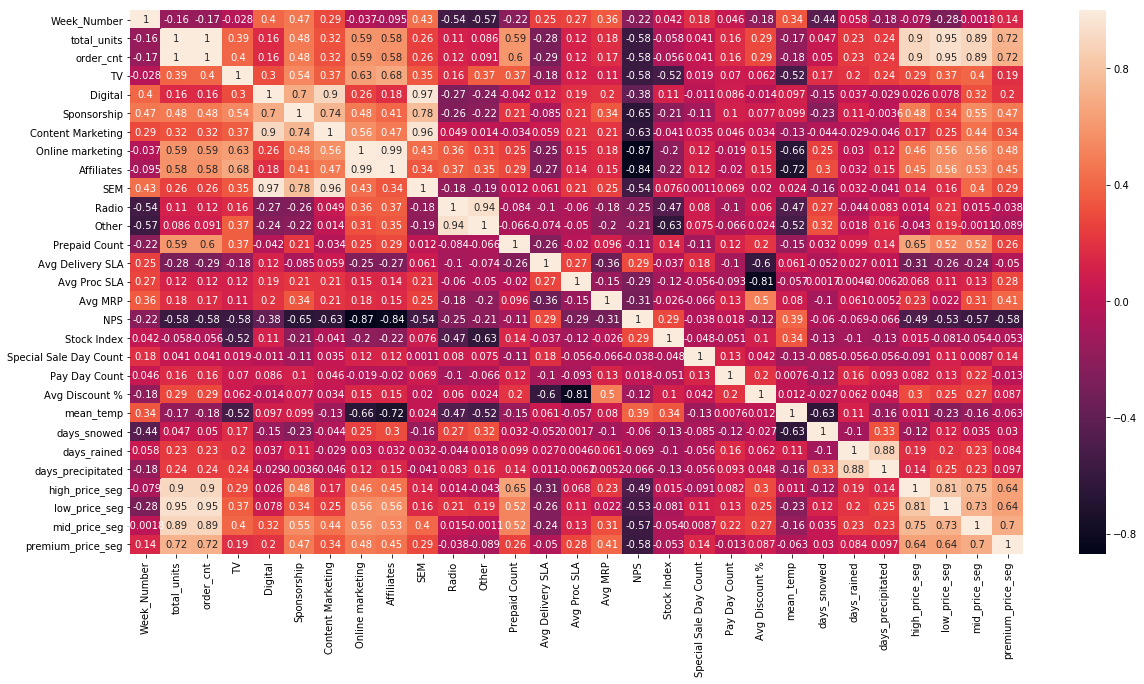

In [226]:
# Correlation matrix for Computer Accessory sub-catg
plt.figure(figsize = (20,10))  # Size of the figure
sns.heatmap(X_CA.corr(),annot = True)


In [227]:
#Dropping the correlated variables and any other unrequired columns
CA_drop_columns = ['Week_Number','order_cnt','high_price_seg','low_price_seg','mid_price_seg','premium_price_seg',
                   'days_precipitated','Other','NPS','Avg Delivery SLA','Avg Proc SLA','mean_temp','SEM','Sponsorship','TV',
                   'Content Marketing','Affiliates']

X_CA = X_CA.drop(CA_drop_columns,axis=1,errors='ignore')

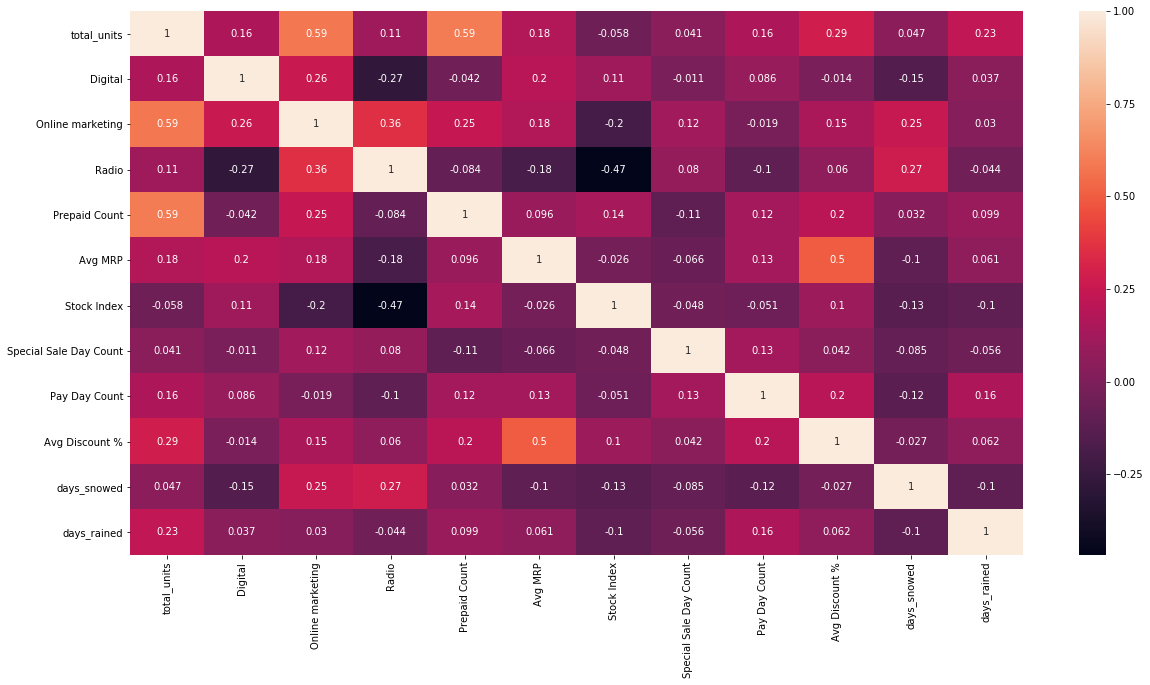

In [228]:
# Correlation matrix for Computer Accessory sub-catg
plt.figure(figsize = (20,10))  # Size of the figure
sns.heatmap(X_CA.corr(),annot = True)


### Identifying the highly correlated variables in Gaming Accessory product sub-category

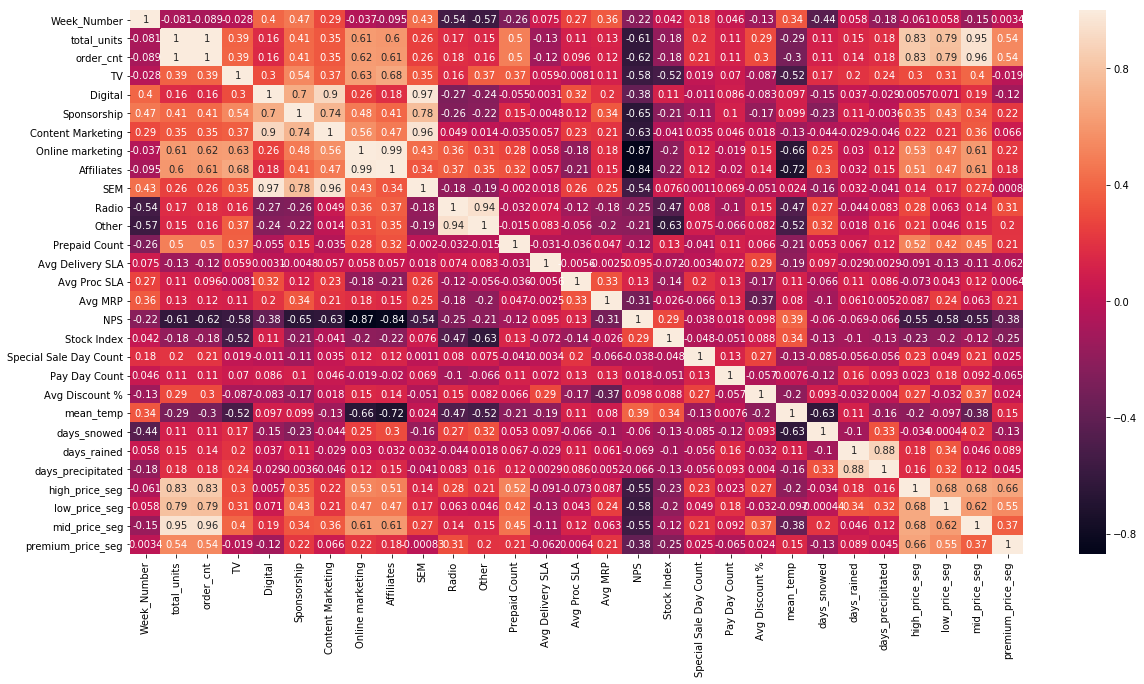

In [229]:
# Correlation matrix for Computer Accessory sub-catg
plt.figure(figsize = (20,10))  # Size of the figure
sns.heatmap(X_GA.corr(),annot = True)

In [230]:
#Dropping the correlated variables and any other unrequired columns
GA_drop_columns = ['Week_Number','order_cnt','high_price_seg','low_price_seg','mid_price_seg',
                   'days_precipitated','Other','NPS','mean_temp','SEM','TV','Content Marketing',
                   'Online marketing','Affiliates','Sponsorship']

X_GA = X_GA.drop(GA_drop_columns,axis=1,errors='ignore')

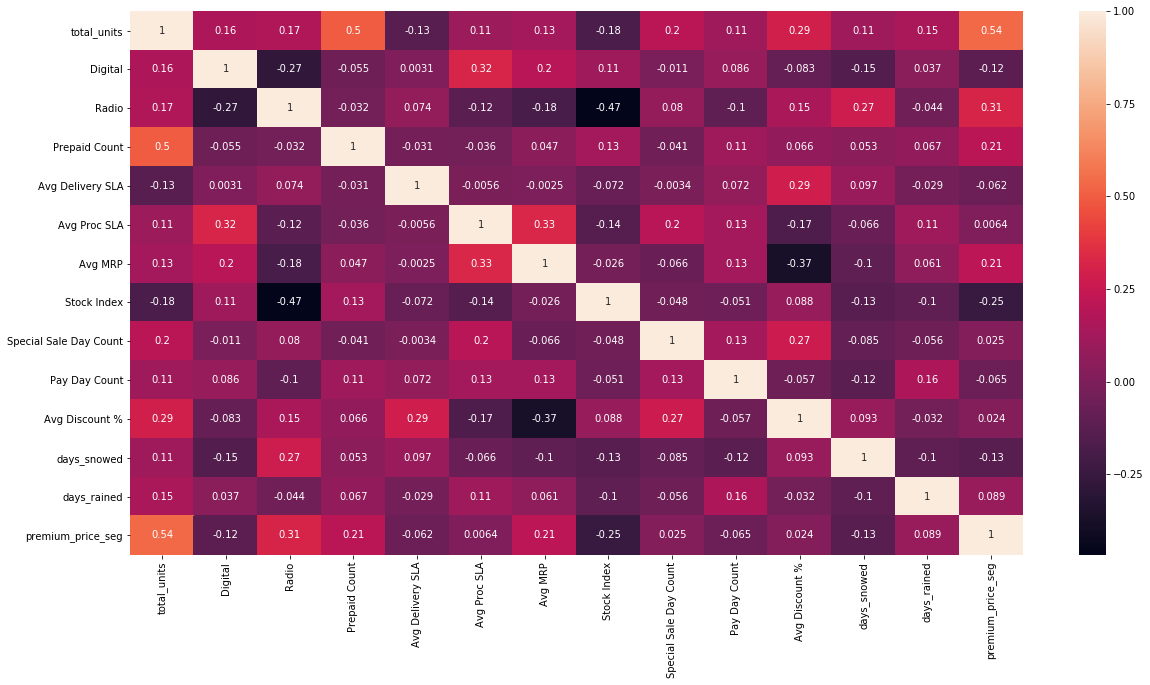

In [231]:
# Correlation matrix for Computer Accessory sub-catg
plt.figure(figsize = (20,10))  # Size of the figure
sns.heatmap(X_GA.corr(),annot = True)


### Identifying the highly correlated variables in Home Audio product sub-category

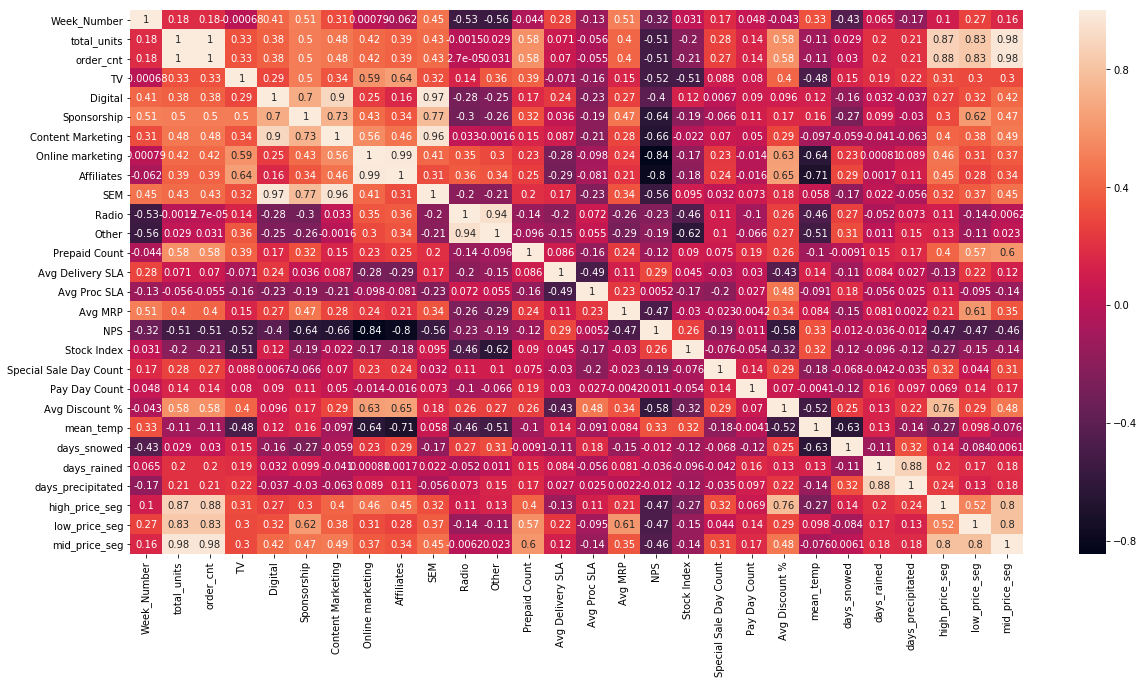

In [232]:
# Correlation matrix for Computer Accessory sub-catg
plt.figure(figsize = (20,10))  # Size of the figure
sns.heatmap(X_HA.corr(),annot = True)

In [234]:
#Dropping the correlated variables and any other unrequired columns
HA_drop_columns = ['Week_Number','order_cnt','high_price_seg','low_price_seg','mid_price_seg',
                   'days_precipitated','Other','NPS','mean_temp','SEM','Sponsorship','Affiliates',
                   'Content Marketing','Avg Discount %']

X_HA = X_HA.drop(HA_drop_columns,axis=1,errors='ignore')

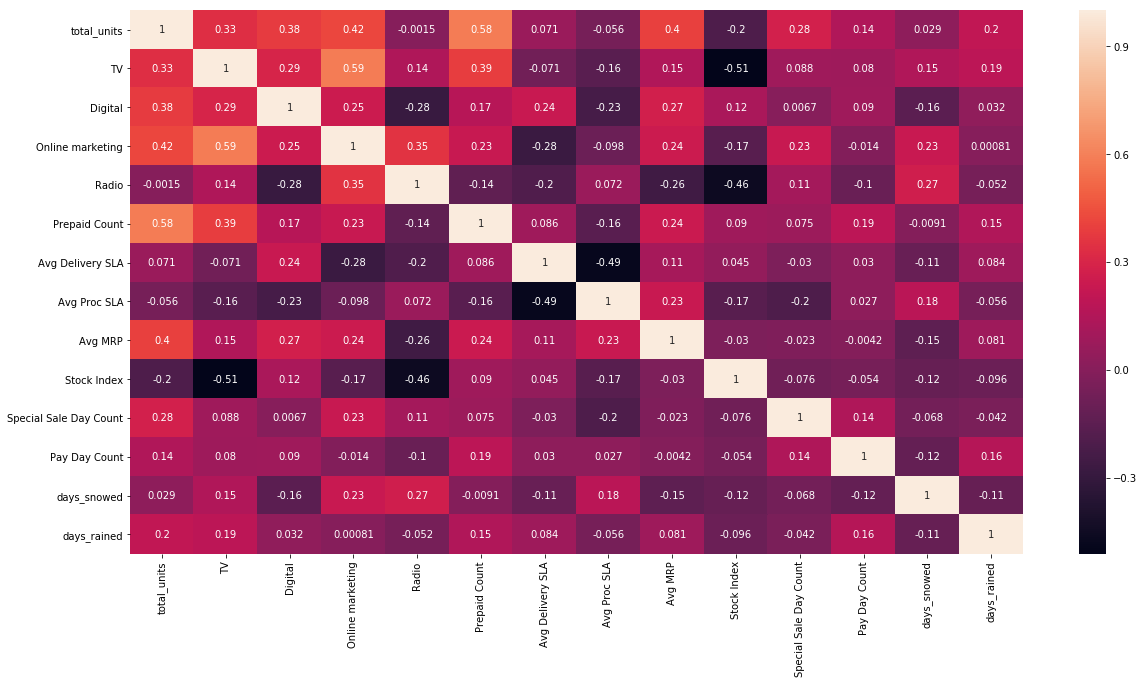

In [235]:
# Correlation matrix for Home Audio Accessory sub-catg
plt.figure(figsize = (20,10))  # Size of the figure
sns.heatmap(X_HA.corr(),annot = True)


### Some reusable functions

In [236]:
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Function for calculating the linear model using statsmodel package
def computeModel(xdata,ydata):
    
    # Adding a constant variable 
    xdata = sm.add_constant(xdata)
    
    #Running the linear model
    lm = sm.OLS(ydata,xdata).fit()
    
    return lm


#Function for calculating the VIF of the linear model
def computeVIF(x_predictors):
    
    vif = pd.DataFrame()
    X = x_predictors
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)

    return vif

### 5.1.3 Building the basic linear model for Computer Accessory

In [237]:
#Performing a cross validation using Lasso regression
from sklearn.model_selection import GridSearchCV

# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000,2000,3000,3500,4000,5000,7500,8000,10000,25000,50000]}


folds = 5

# cross validation
from sklearn.linear_model import Lasso

lasso_ca=Lasso()
lasso_regressor_ca = GridSearchCV(estimator = lasso_ca, 
                                  param_grid =params, 
                                  scoring= 'r2', 
                                  cv = folds, 
                                  return_train_score=True,
                                  verbose = 1)            

lasso_regressor_ca.fit(X_CA, y_CA)

Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    1.0s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000, 2000, 3000, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1)

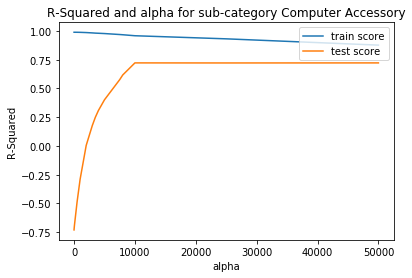

In [239]:
#Creating a data frame with the results of lasso regression
lasso_cv_results_ca = pd.DataFrame(lasso_regressor_ca.cv_results_)

# plotting mean test and train scoes with alpha 
lasso_cv_results_ca['param_alpha'] = lasso_cv_results_ca['param_alpha'].astype('float32')

# plotting
plt.plot(lasso_cv_results_ca['param_alpha'], lasso_cv_results_ca['mean_train_score'])
plt.plot(lasso_cv_results_ca['param_alpha'], lasso_cv_results_ca['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R-Squared')

plt.title("R-Squared and alpha for sub-category Computer Accessory")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [240]:
#Printing the optimal value of alpha and the corresponding R-squared value
print(lasso_regressor_ca.best_params_)
print(lasso_regressor_ca.best_score_)

{'alpha': 10000}
0.7222462004741224


In [241]:
#Fitting the model using the optimal value of alpha
CA_lasso_alpha =10000
CA_lasso = Lasso(alpha=CA_lasso_alpha)    
CA_lasso.fit(X_CA, y_CA)

Lasso(alpha=10000, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [242]:
#Creating a data frame with the co-efficients estimated by lasso regression along with their corresponding features
CA_lasso_features = pd.DataFrame({"Feature":X_CA.columns,"Coefficients":np.transpose(CA_lasso.coef_)})
CA_lasso_features = CA_lasso_features.loc[CA_lasso_features['Coefficients'] != 0]
CA_lasso_features.sort_values(by=['Coefficients'],ascending=False)

,Feature,Coefficients
0,total_units,4.978254e+06
5,Avg MRP,3.145290e+05
2,Online marketing,9.097138e+04
3,Radio,-9.372713e+04
6,Stock Index,-1.282499e+05


In [243]:
vif = computeVIF(X_CA[CA_lasso_features.Feature])
vif

,Features,VIF
1,Online marketing,9.45
0,total_units,8.62
3,Avg MRP,7.81
4,Stock Index,3.96
2,Radio,1.68


In [244]:
CA_lasso.intercept_

195934.3404526729

### 5.1.4 Building the basic linear model for Gaming Accessory

In [245]:
#Performing a cross validation using Lasso regression
from sklearn.model_selection import GridSearchCV

# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000,2000,3000,3500,4000,5000,7500,8000,10000,25000,50000]}

folds = 5

# cross validation
from sklearn.linear_model import Lasso
lasso_ga=Lasso()
lasso_regressor_ga = GridSearchCV(estimator = lasso_ga, 
                                  param_grid = params, 
                                  scoring= 'r2', 
                                  cv = folds, 
                                  return_train_score=True,
                                  verbose = 1)            

lasso_regressor_ga.fit(X_GA, y_GA)

Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    1.6s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000, 2000, 3000, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1)

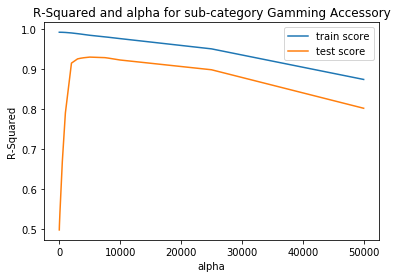

In [246]:
#Creating a data frame with the results of lasso regression
lasso_cv_results_ga = pd.DataFrame(lasso_regressor_ga.cv_results_)

# plotting mean test and train scoes with alpha 
lasso_cv_results_ga['param_alpha'] = lasso_cv_results_ga['param_alpha'].astype('float32')

# plotting
plt.plot(lasso_cv_results_ga['param_alpha'], lasso_cv_results_ga['mean_train_score'])
plt.plot(lasso_cv_results_ga['param_alpha'], lasso_cv_results_ga['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R-Squared')

plt.title("R-Squared and alpha for sub-category Gamming Accessory")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [247]:
#Printing the optimal value of alpha and the corresponding R-squared value
print(lasso_regressor_ga.best_params_)
print(lasso_regressor_ga.best_score_)

{'alpha': 5000}
0.9292163534505515


In [258]:
#Fitting the model using the optimal value of alpha
GA_lasso_alpha =5000
GA_lasso = Lasso(alpha=GA_lasso_alpha)    
GA_lasso.fit(X_GA, y_GA)

Lasso(alpha=5000, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [259]:
#Creating a data frame with the co-efficients estimated by lasso regression along with their corresponding features
GA_lasso_features = pd.DataFrame({"Feature":X_GA.columns,"Coefficients":np.transpose(GA_lasso.coef_)})
GA_lasso_features = GA_lasso_features.loc[GA_lasso_features['Coefficients'] != 0]
GA_lasso_features.sort_values(by=['Coefficients'],ascending=False)

,Feature,Coefficients
0,total_units,5.400098e+06
13,premium_price_seg,1.023139e+06
3,Prepaid Count,2.697812e+05
4,Avg Delivery SLA,1.636490e+04
9,Pay Day Count,-2.530649e+04
7,Stock Index,-4.771548e+04
10,Avg Discount %,-3.263669e+05


In [261]:
vif = computeVIF(X_GA[GA_lasso_features.Feature])
vif

,Features,VIF
0,total_units,11.75
5,Avg Discount %,7.86
2,Avg Delivery SLA,7.50
6,premium_price_seg,5.96
1,Prepaid Count,3.76
3,Stock Index,3.75
4,Pay Day Count,1.95


In [262]:
GA_lasso.intercept_

279527.2058977494

### 5.1.5 Building the basic linear model for Home Audio

In [263]:
#Performing a cross validation using Lasso regression
from sklearn.model_selection import GridSearchCV

# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000,2000,3000,3500,4000,5000,7500,8000,10000,25000,50000]}

folds = 5

# cross validation
from sklearn.linear_model import Lasso
lasso_ha=Lasso()
lasso_regressor_ha = GridSearchCV(estimator = lasso_ha, 
                                  param_grid = params, 
                                  scoring= 'r2', 
                                  cv = folds, 
                                  return_train_score=True,
                                  verbose = 1)            

lasso_regressor_ha.fit(X_HA, y_HA)

Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    0.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000, 2000, 3000, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1)

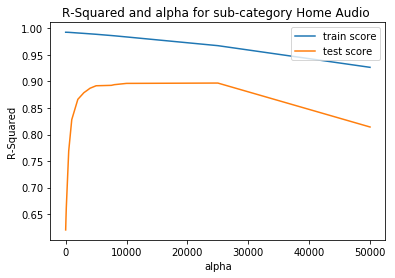

In [264]:
#Creating a data frame with the results of lasso regression
lasso_cv_results_ha = pd.DataFrame(lasso_regressor_ha.cv_results_)

# plotting mean test and train scoes with alpha 
lasso_cv_results_ha['param_alpha'] = lasso_cv_results_ha['param_alpha'].astype('float32')

# plotting
plt.plot(lasso_cv_results_ha['param_alpha'], lasso_cv_results_ha['mean_train_score'])
plt.plot(lasso_cv_results_ha['param_alpha'], lasso_cv_results_ha['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R-Squared')

plt.title("R-Squared and alpha for sub-category Home Audio ")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [272]:
lasso_cv_results_ha

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.003392,0.000487,0.001395,4.871005e-04,0.0001,{'alpha': 0.0001},0.666468,0.448788,0.892025,0.918405,...,0.620344,0.279865,38,0.991025,0.992305,0.989152,0.994618,0.996857,0.992791,0.002701
1,0.003591,0.001619,0.000998,2.949460e-06,0.0010,{'alpha': 0.001},0.666468,0.448789,0.892025,0.918405,...,0.620344,0.279864,37,0.991025,0.992305,0.989152,0.994618,0.996857,0.992791,0.002701
2,0.002400,0.000497,0.000393,4.810017e-04,0.0100,{'alpha': 0.01},0.666469,0.448800,0.892025,0.918405,...,0.620348,0.279861,36,0.991025,0.992305,0.989152,0.994618,0.996857,0.992791,0.002701
3,0.002194,0.000399,0.000599,4.889706e-04,0.0500,{'alpha': 0.05},0.666476,0.448852,0.892026,0.918406,...,0.620366,0.279845,35,0.991025,0.992305,0.989152,0.994618,0.996857,0.992791,0.002701
4,0.001793,0.000415,0.000998,6.975526e-07,0.1000,{'alpha': 0.1},0.666484,0.448915,0.892026,0.918408,...,0.620389,0.279826,34,0.991025,0.992305,0.989152,0.994618,0.996857,0.992791,0.002701
5,0.001795,0.000745,0.000599,4.886952e-04,0.2000,{'alpha': 0.2},0.666500,0.449044,0.892028,0.918411,...,0.620434,0.279788,33,0.991025,0.992305,0.989152,0.994618,0.996857,0.992791,0.002701
6,0.002000,0.000631,0.000991,1.228076e-05,0.3000,{'alpha': 0.3},0.666516,0.449172,0.892030,0.918415,...,0.620479,0.279749,32,0.991025,0.992305,0.989152,0.994618,0.996857,0.992791,0.002701
7,0.001596,0.000488,0.000996,1.675050e-06,0.4000,{'alpha': 0.4},0.666532,0.449299,0.892032,0.918418,...,0.620524,0.279711,31,0.991025,0.992305,0.989152,0.994618,0.996857,0.992791,0.002701
8,0.001795,0.000977,0.000997,6.143617e-07,0.5000,{'alpha': 0.5},0.666547,0.449428,0.892034,0.918421,...,0.620570,0.279672,30,0.991025,0.992305,0.989152,0.994618,0.996857,0.992791,0.002701
9,0.002002,0.000631,0.000791,3.957835e-04,0.6000,{'alpha': 0.6},0.666564,0.449554,0.892036,0.918425,...,0.620614,0.279634,29,0.991025,0.992305,0.989152,0.994618,0.996857,0.992791,0.002701


In [266]:
#Printing the optimal value of alpha and the corresponding R-squared value
print(lasso_regressor_ha.best_params_)
print(lasso_regressor_ha.best_score_)

{'alpha': 25000}
0.8970490060912302


In [276]:
#Fitting the model using the optimal value of alpha
HA_lasso_alpha = 25000
HA_lasso = Lasso(alpha=HA_lasso_alpha)    
HA_lasso.fit(X_HA, y_HA)

Lasso(alpha=25000, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [277]:
#Creating a data frame with the co-efficients estimated by lasso regression along with their corresponding features
HA_lasso_features = pd.DataFrame({"Feature":X_HA.columns,"Coefficients":np.transpose(HA_lasso.coef_)})
HA_lasso_features = HA_lasso_features.loc[HA_lasso_features['Coefficients'] != 0]
HA_lasso_features.sort_values(by=['Coefficients'],ascending=False)

,Feature,Coefficients
0,total_units,1.172228e+07
3,Online marketing,1.251614e+05
10,Special Sale Day Count,1.012816e+05


In [278]:
vif = computeVIF(X_HA[HA_lasso_features.Feature])
vif

,Features,VIF
0,total_units,5.13
1,Online marketing,5.01
2,Special Sale Day Count,1.35


In [451]:
HA_lasso.intercept_

316825.51371183665

## 5.2 Some reusable methods

### Creating a lagged variable with a given shift period

In [295]:
#Function to create a lagged variable with a given shift period
# df - Dataframe containing the data
# varname - Name of the variable to be lagged
# period -  Period by which the variable is to be lagged
def createLagVariable(df,varname,period):
    
    s = df[varname].shift(period)
    lagvarname = varname + '_lag_' + str(period)
    
    return (lagvarname,s)


### Creating a dataframe with lagged variables for ARDL(m,n) model

In [296]:
#Function to create a dataframe for the ARDL(m,n) model where
# m : Lag for the dependent variable
# n : Lag for the explanatory variables
# Constraints: m, n > 0
def createLaggedDataFrame(df,depVar,expVars,m,n):
    
    lagged_df = df.copy()
    
    mlags = list(range(1,m+1))
    nlags = list(range(1,n+1))
    
    #Creating the m lag variables for the dependent variable
    for i in mlags:
        depVarLagInfo = createLagVariable(lagged_df,depVar,i)
        depVarLagName = depVarLagInfo[0]
        depVarLagSeries = depVarLagInfo[1]
        lagged_df[depVarLagName] = depVarLagSeries
        #print("Create lagged dependent variable " + depVarLagName)
    
    
    #Creating the lag variables for each of the explanatory variables
    for e in expVars:
        
        #Creating n lag variables for each of the explanatory variables
        for i in nlags:
            expVarLagInfo = createLagVariable(lagged_df,e,i)
            expVarLagName = expVarLagInfo[0]
            expVarLagSeries = expVarLagInfo[1]
            lagged_df[expVarLagName] = expVarLagSeries
            #print("Create lagged explanatory variable " + expVarLagName)
                
        
    return lagged_df    

### Generate ARDL model

In [480]:
# list of alphas to tune
params = {'alpha': [0.00001,0.0001,0.001,0.01,0.1,1,10, 20, 50, 100, 500, 1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,15000,20000,25000,30000,50000,75000,100000]}

folds = 5

#df : Base data frame to be used for the ARDL model
#depVarName: Name of the dependent variable in df
#m: Lag for the dependent variable
#n: Lag for the explanatory variables
def GenerateOptimizedARDLModel(df,depVarName,m,n):
    
    #Creating the list of explanatory column names
    columns = df.columns
    columns = columns.drop([depVarName])
    columnNames = list(columns)
    
    results = pd.DataFrame(columns=['M','N','Best Params','Best Score'])
    
    #Creating a list of m and n values to search for the optimal ARDL model
    m_params = list(range(1,m+1))
    n_params = list(range(1,n+1))
    
    for i in m_params:
        
        for j in n_params:
        
            print("Performing GridSearch with ARDL("+str(i)+","+str(j)+") model")
            #Creating the lagged data frame for the ARDL(m,n) model
            lagged_df = createLaggedDataFrame(df,depVarName,columnNames,i,j)

            #Drop any missing values
            lagged_df.dropna(inplace=True)

            #Split data set into X & Y
            y = lagged_df[depVarName]
            X = lagged_df.drop([depVarName],axis=1)

            #Using MinMax Scaler for scaling the lagged data frame
            scaler = MinMaxScaler()
            cols = X.columns
            X[cols] = scaler.fit_transform(X[cols])
            X.columns = cols


            #Performing a cross validation using Lasso regression
            lasso=Lasso()
            lasso_regressor = GridSearchCV(estimator = lasso, 
                                           param_grid = params, 
                                           scoring= 'r2', 
                                           cv = folds, 
                                           return_train_score=True,
                                           verbose = 0)            

            lasso_regressor.fit(X, y)
            
            ##Appending to the results data frame
            results = results.append({'M':i,
                                      'N':j,
                                      'Best Params':lasso_regressor.best_params_,
                                      'Best Score':lasso_regressor.best_score_},ignore_index=True)
            
    return results          
    

### Function for calculating the linear model using statsmodel package

In [291]:
def computeModel(xdata,ydata):
    
    # Adding a constant variable 
    xdata = sm.add_constant(xdata)
    
    #Running the linear model
    lm = sm.OLS(ydata,xdata).fit()
    
    return lm

### Function for calculating the VIF of the linear model

In [292]:
def computeVIF(x_predictors):
    
    vif = pd.DataFrame()
    X = x_predictors
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)

    return vif

## 5.2 Distributed Lag Model

In [283]:
all_features_CA_subcatg.head()

,Week_Number,total_gmv,total_units,order_cnt,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,...,Pay Day Count,Avg Discount %,mean_temp,days_snowed,days_rained,days_precipitated,high_price_seg,low_price_seg,mid_price_seg,premium_price_seg
0,1,2695255.0,5123.0,5009.0,0.989032,0.102968,0.948387,0.203226,5.170968,1.664194,...,0,50.401244,0.066667,2.0,2.0,3.0,598,2957,1533,35
1,2,2076847.0,3644.0,3571.0,0.989032,0.102968,0.948387,0.203226,5.170968,1.664194,...,1,49.745695,-3.733333,0.0,1.0,1.0,521,1852,1239,32
2,3,2683274.0,4756.0,4652.0,0.989032,0.102968,0.948387,0.203226,5.170968,1.664194,...,0,49.652850,-2.766667,1.0,0.0,1.0,595,2971,1145,45
3,4,2186104.0,3311.0,3240.0,0.989032,0.102968,0.948387,0.203226,5.170968,1.664194,...,0,44.976952,-1.800000,1.0,0.0,1.0,605,1730,936,40
4,5,2848712.0,5318.0,5182.0,0.624209,0.461674,2.830306,0.144048,4.801606,1.560522,...,1,52.290783,3.200000,1.0,2.0,3.0,811,2914,1533,60


In [284]:
all_features_GA_subcatg.head()

,Week_Number,total_gmv,total_units,order_cnt,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,...,Pay Day Count,Avg Discount %,mean_temp,days_snowed,days_rained,days_precipitated,high_price_seg,low_price_seg,mid_price_seg,premium_price_seg
0,1,2956408.00,4360.0,4249.0,0.989032,0.102968,0.948387,0.203226,5.170968,1.664194,...,0,47.876333,0.066667,2.0,2.0,3.0,1104,1103,1875,176
1,2,2632506.00,3855.0,3762.0,0.989032,0.102968,0.948387,0.203226,5.170968,1.664194,...,1,45.578609,-3.733333,0.0,1.0,1.0,794,874,1985,126
2,3,3904175.30,5204.0,5038.0,0.989032,0.102968,0.948387,0.203226,5.170968,1.664194,...,0,46.309516,-2.766667,1.0,0.0,1.0,1007,964,2921,208
3,4,2374740.50,3403.0,3318.0,0.989032,0.102968,0.948387,0.203226,5.170968,1.664194,...,0,44.488841,-1.800000,1.0,0.0,1.0,552,812,1902,118
4,5,2489931.85,4050.0,3946.0,0.624209,0.461674,2.830306,0.144048,4.801606,1.560522,...,1,45.621655,3.200000,1.0,2.0,3.0,635,1043,2295,66


In [285]:
all_features_HA_subcatg.head()

,Week_Number,total_gmv,total_units,order_cnt,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,...,Special Sale Day Count,Pay Day Count,Avg Discount %,mean_temp,days_snowed,days_rained,days_precipitated,high_price_seg,low_price_seg,mid_price_seg
0,1,6077631.00,3154.0,3146.0,0.989032,0.102968,0.948387,0.203226,5.170968,1.664194,...,0,0,45.383762,0.066667,2.0,2.0,3.0,1294,477,1383
1,2,4000777.00,2115.0,2110.0,0.989032,0.102968,0.948387,0.203226,5.170968,1.664194,...,0,1,39.548386,-3.733333,0.0,1.0,1.0,688,411,1016
2,3,4479235.45,2491.0,2474.0,0.989032,0.102968,0.948387,0.203226,5.170968,1.664194,...,3,0,40.273357,-2.766667,1.0,0.0,1.0,710,502,1279
3,4,3721562.00,2060.0,2049.0,0.989032,0.102968,0.948387,0.203226,5.170968,1.664194,...,0,0,37.979152,-1.800000,1.0,0.0,1.0,584,480,996
4,5,6108654.00,3115.0,3101.0,0.624209,0.461674,2.830306,0.144048,4.801606,1.560522,...,2,1,42.683294,3.200000,1.0,2.0,3.0,1218,536,1361


In [298]:
#Dropping the correlated variables
all_features_CA_revised = all_features_CA_subcatg.drop(CA_drop_columns,axis=1)

In [299]:
CA_results = GenerateOptimizedARDLModel(all_features_CA_revised,'total_gmv',5,5)

Performing GridSearch with ARDL(1,1) model
Performing GridSearch with ARDL(1,2) model
Performing GridSearch with ARDL(1,3) model
Performing GridSearch with ARDL(1,4) model
Performing GridSearch with ARDL(1,5) model
Performing GridSearch with ARDL(2,1) model
Performing GridSearch with ARDL(2,2) model
Performing GridSearch with ARDL(2,3) model
Performing GridSearch with ARDL(2,4) model
Performing GridSearch with ARDL(2,5) model
Performing GridSearch with ARDL(3,1) model
Performing GridSearch with ARDL(3,2) model
Performing GridSearch with ARDL(3,3) model
Performing GridSearch with ARDL(3,4) model
Performing GridSearch with ARDL(3,5) model
Performing GridSearch with ARDL(4,1) model
Performing GridSearch with ARDL(4,2) model
Performing GridSearch with ARDL(4,3) model
Performing GridSearch with ARDL(4,4) model
Performing GridSearch with ARDL(4,5) model
Performing GridSearch with ARDL(5,1) model
Performing GridSearch with ARDL(5,2) model
Performing GridSearch with ARDL(5,3) model
Performing 

In [301]:
CA_results.sort_values("Best Score",axis=0,ascending=False).head()

,M,N,Best Params,Best Score
15,4,1,{'alpha': 1000},0.820079
20,5,1,{'alpha': 1000},0.817409
10,3,1,{'alpha': 2000},0.815397
14,3,5,{'alpha': 10.0},0.777370
19,4,5,{'alpha': 10.0},0.765496


In [302]:
#Dropping the correlated variables
all_features_GA_revised = all_features_GA_subcatg.drop(GA_drop_columns,axis=1)

In [303]:
GA_results = GenerateOptimizedARDLModel(all_features_GA_revised,'total_gmv',5,5)

Performing GridSearch with ARDL(1,1) model
Performing GridSearch with ARDL(1,2) model
Performing GridSearch with ARDL(1,3) model
Performing GridSearch with ARDL(1,4) model
Performing GridSearch with ARDL(1,5) model
Performing GridSearch with ARDL(2,1) model
Performing GridSearch with ARDL(2,2) model
Performing GridSearch with ARDL(2,3) model
Performing GridSearch with ARDL(2,4) model
Performing GridSearch with ARDL(2,5) model
Performing GridSearch with ARDL(3,1) model
Performing GridSearch with ARDL(3,2) model
Performing GridSearch with ARDL(3,3) model
Performing GridSearch with ARDL(3,4) model
Performing GridSearch with ARDL(3,5) model
Performing GridSearch with ARDL(4,1) model
Performing GridSearch with ARDL(4,2) model
Performing GridSearch with ARDL(4,3) model
Performing GridSearch with ARDL(4,4) model
Performing GridSearch with ARDL(4,5) model
Performing GridSearch with ARDL(5,1) model
Performing GridSearch with ARDL(5,2) model
Performing GridSearch with ARDL(5,3) model
Performing 

In [304]:
GA_results.sort_values("Best Score",axis=0,ascending=False).head()

,M,N,Best Params,Best Score
23,5,4,{'alpha': 20},0.919060
0,1,1,{'alpha': 6000},0.910899
5,2,1,{'alpha': 6000},0.909430
6,2,2,{'alpha': 7000},0.908604
1,1,2,{'alpha': 7000},0.908604


In [305]:
#Dropping the correlated variables
all_features_HA_revised = all_features_HA_subcatg.drop(HA_drop_columns,axis=1,errors='ignore')

In [306]:
HA_results = GenerateOptimizedARDLModel(all_features_HA_revised,'total_gmv',5,5)

Performing GridSearch with ARDL(1,1) model
Performing GridSearch with ARDL(1,2) model
Performing GridSearch with ARDL(1,3) model
Performing GridSearch with ARDL(1,4) model
Performing GridSearch with ARDL(1,5) model
Performing GridSearch with ARDL(2,1) model
Performing GridSearch with ARDL(2,2) model
Performing GridSearch with ARDL(2,3) model
Performing GridSearch with ARDL(2,4) model
Performing GridSearch with ARDL(2,5) model
Performing GridSearch with ARDL(3,1) model
Performing GridSearch with ARDL(3,2) model
Performing GridSearch with ARDL(3,3) model
Performing GridSearch with ARDL(3,4) model
Performing GridSearch with ARDL(3,5) model
Performing GridSearch with ARDL(4,1) model
Performing GridSearch with ARDL(4,2) model
Performing GridSearch with ARDL(4,3) model
Performing GridSearch with ARDL(4,4) model
Performing GridSearch with ARDL(4,5) model
Performing GridSearch with ARDL(5,1) model
Performing GridSearch with ARDL(5,2) model
Performing GridSearch with ARDL(5,3) model
Performing 

In [307]:
HA_results.sort_values("Best Score",axis=0,ascending=False).head()

,M,N,Best Params,Best Score
23,5,4,{'alpha': 15000},0.945693
24,5,5,{'alpha': 15000},0.940255
4,1,5,{'alpha': 15000},0.940255
9,2,5,{'alpha': 15000},0.940255
19,4,5,{'alpha': 15000},0.940255


### 5.2.1 Fine tuning ARDL model for Computer Accessory product sub-category

#### 5.2.1.1 Fitting the ARDL model using the optimal values

In [343]:
CA_results.sort_values("Best Score",axis=0,ascending=False).head(25)

,M,N,Best Params,Best Score
15,4,1,{'alpha': 1000},0.820079
20,5,1,{'alpha': 1000},0.817409
10,3,1,{'alpha': 2000},0.815397
14,3,5,{'alpha': 10.0},0.777370
19,4,5,{'alpha': 10.0},0.765496
24,5,5,{'alpha': 10.0},0.765205
16,4,2,{'alpha': 1000},0.756666
0,1,1,{'alpha': 9000},0.734815
11,3,2,{'alpha': 2000},0.731252
4,1,5,{'alpha': 10.0},0.720240


In [309]:
all_features_CA_revised.head()

,total_gmv,total_units,Digital,Online marketing,Radio,Prepaid Count,Avg MRP,Stock Index,Special Sale Day Count,Pay Day Count,Avg Discount %,days_snowed,days_rained
0,2695255.0,5123.0,0.102968,5.170968,0.609677,948,1232.377121,1052.0,0,0,50.401244,2.0,2.0
1,2076847.0,3644.0,0.102968,5.170968,0.609677,752,1297.492859,1052.0,0,1,49.745695,0.0,1.0
2,2683274.0,4756.0,0.102968,5.170968,0.609677,1094,1234.543207,1052.0,3,0,49.652850,1.0,0.0
3,2186104.0,3311.0,0.102968,5.170968,0.609677,658,1377.846296,1052.0,0,0,44.976952,1.0,0.0
4,2848712.0,5318.0,0.461674,4.801606,0.000000,1076,1292.669626,1222.0,2,1,52.290783,1.0,2.0


In [330]:
#Creating the lagged data frame for ARDL(4,1) model for Computer Accessory
CA_columns = all_features_CA_revised.columns
CA_columns = CA_columns.drop(["total_gmv"])
CA_colnames = list(CA_columns)
CA_lagged_df = createLaggedDataFrame(all_features_CA_revised,"total_gmv",CA_colnames,1,1)

In [331]:
CA_lagged_df.head()

,total_gmv,total_units,Digital,Online marketing,Radio,Prepaid Count,Avg MRP,Stock Index,Special Sale Day Count,Pay Day Count,...,Online marketing_lag_1,Radio_lag_1,Prepaid Count_lag_1,Avg MRP_lag_1,Stock Index_lag_1,Special Sale Day Count_lag_1,Pay Day Count_lag_1,Avg Discount %_lag_1,days_snowed_lag_1,days_rained_lag_1
0,2695255.0,5123.0,0.102968,5.170968,0.609677,948,1232.377121,1052.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2076847.0,3644.0,0.102968,5.170968,0.609677,752,1297.492859,1052.0,0,1,...,5.170968,0.609677,948.0,1232.377121,1052.0,0.0,0.0,50.401244,2.0,2.0
2,2683274.0,4756.0,0.102968,5.170968,0.609677,1094,1234.543207,1052.0,3,0,...,5.170968,0.609677,752.0,1297.492859,1052.0,0.0,1.0,49.745695,0.0,1.0
3,2186104.0,3311.0,0.102968,5.170968,0.609677,658,1377.846296,1052.0,0,0,...,5.170968,0.609677,1094.0,1234.543207,1052.0,3.0,0.0,49.652850,1.0,0.0
4,2848712.0,5318.0,0.461674,4.801606,0.000000,1076,1292.669626,1222.0,2,1,...,5.170968,0.609677,658.0,1377.846296,1052.0,0.0,0.0,44.976952,1.0,0.0


In [332]:
#Drop any missing values
CA_lagged_df.dropna(inplace=True)

In [333]:
#Split data set into X & Y
y_CA = CA_lagged_df["total_gmv"]
X_CA = CA_lagged_df.drop(["total_gmv"],axis=1)


In [334]:
#Using MinMax Scaler for scaling the lagged data frame
scaler = MinMaxScaler()
cols = X_CA.columns
X_CA[cols] = scaler.fit_transform(X_CA[cols])
X_CA.columns = cols

In [339]:
#Fitting the model using the optimal value of alpha
CA_lasso_alpha =10000
CA_lasso = Lasso(alpha=CA_lasso_alpha)    
CA_lasso.fit(X_CA, y_CA)

Lasso(alpha=10000, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [340]:
#Creating a data frame with the co-efficients estimated by lasso regression along with their corresponding features
CA_lasso_features = pd.DataFrame({"Feature":X_CA.columns,"Coefficients":np.transpose(CA_lasso.coef_)})
CA_lasso_features = CA_lasso_features.loc[CA_lasso_features['Coefficients'] != 0]
CA_lasso_features.sort_values(by=['Coefficients'],ascending=False)

,Feature,Coefficients
0,total_units,4.999541e+06
5,Avg MRP,3.155246e+05
14,Digital_lag_1,7.855430e+04
2,Online marketing,6.249509e+04
16,Radio_lag_1,-4.400489e+04
6,Stock Index,-1.341610e+05


In [341]:
CA_lasso_features.index.size

6

In [342]:
vif = computeVIF(X_CA[CA_lasso_features.Feature])
vif

,Features,VIF
1,Online marketing,9.76
0,total_units,8.45
2,Avg MRP,7.79
3,Stock Index,3.80
4,Digital_lag_1,1.84
5,Radio_lag_1,1.63


### 5.2.2 Fine tuning ARDL model for Gaming Accessory product sub-category

#### 5.2.2.1 Fitting the ARDL model using the optimal values

In [370]:
GA_results.sort_values("Best Score",axis=0,ascending=False).head(25)

,M,N,Best Params,Best Score
23,5,4,{'alpha': 20},0.919060
0,1,1,{'alpha': 6000},0.910899
5,2,1,{'alpha': 6000},0.909430
6,2,2,{'alpha': 7000},0.908604
1,1,2,{'alpha': 7000},0.908604
10,3,1,{'alpha': 4000},0.903298
3,1,4,{'alpha': 50},0.900081
18,4,4,{'alpha': 50},0.899004
13,3,4,{'alpha': 50},0.898390
8,2,4,{'alpha': 50},0.898081


In [389]:
#Creating the lagged data frame for ARDL(1,1) model for Gaming Accessory
GA_columns = all_features_GA_revised.columns
GA_columns = GA_columns.drop(["total_gmv"])
GA_colnames = list(GA_columns)
GA_lagged_df = createLaggedDataFrame(all_features_GA_revised,"total_gmv",GA_colnames,1,1)

In [390]:
#Drop any missing values
GA_lagged_df.dropna(inplace=True)

In [391]:
#Split data set into X & Y
y_GA = GA_lagged_df["total_gmv"]
X_GA = GA_lagged_df.drop(["total_gmv"],axis=1)

In [392]:
#Using MinMax Scaler for scaling the lagged data frame
scaler = MinMaxScaler()
cols = X_GA.columns
X_GA[cols] = scaler.fit_transform(X_GA[cols])
X_GA.columns = cols

In [394]:
#Fitting the model using the optimal value of alpha
GA_lasso_alpha =6000
GA_lasso = Lasso(alpha=GA_lasso_alpha)    
GA_lasso.fit(X_GA, y_GA)

Lasso(alpha=6000, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [395]:
#Creating a data frame with the co-efficients estimated by lasso regression along with their corresponding features
GA_lasso_features = pd.DataFrame({"Feature":X_GA.columns,"Coefficients":np.transpose(GA_lasso.coef_)})
GA_lasso_features = GA_lasso_features.loc[GA_lasso_features['Coefficients'] != 0]
GA_lasso_features.sort_values(by=['Coefficients'],ascending=False)

,Feature,Coefficients
0,total_units,5.345597e+06
13,premium_price_seg,1.016136e+06
3,Prepaid Count,2.535090e+05
14,total_gmv_lag_1,8.728594e+04
9,Pay Day Count,-1.770664e+04
22,Stock Index_lag_1,-7.057682e+04
10,Avg Discount %,-2.466522e+05


In [396]:
GA_lasso_features.index.size

7

In [397]:
vif = computeVIF(X_GA[GA_lasso_features.Feature])
vif

,Features,VIF
0,total_units,11.38
4,premium_price_seg,6.18
3,Avg Discount %,5.41
5,total_gmv_lag_1,5.13
6,Stock Index_lag_1,3.60
1,Prepaid Count,3.46
2,Pay Day Count,1.84


### 5.2.3 Fine tuning ARDL model for Home Audio product sub-category

#### 5.2.3.1 Fitting the ARDL model using the optimal values

In [434]:
HA_results.sort_values("Best Score",axis=0,ascending=False).head(25)

,M,N,Best Params,Best Score
23,5,4,{'alpha': 15000},0.945693
24,5,5,{'alpha': 15000},0.940255
4,1,5,{'alpha': 15000},0.940255
9,2,5,{'alpha': 15000},0.940255
19,4,5,{'alpha': 15000},0.940255
14,3,5,{'alpha': 15000},0.940255
22,5,3,{'alpha': 15000},0.940155
20,5,1,{'alpha': 15000},0.938008
21,5,2,{'alpha': 15000},0.937860
3,1,4,{'alpha': 15000},0.935362


In [436]:
#Creating the lagged data frame for ARDL(5,4) model for Home Audio
HA_columns = all_features_HA_revised.columns
HA_columns = HA_columns.drop(["total_gmv"])
HA_colnames = list(HA_columns)
HA_lagged_df = createLaggedDataFrame(all_features_HA_revised,"total_gmv",HA_colnames,5,4)

In [437]:
#Drop any missing values
HA_lagged_df.dropna(inplace=True)

In [438]:
#Split data set into X & Y
y_HA = HA_lagged_df["total_gmv"]
X_HA = HA_lagged_df.drop(["total_gmv"],axis=1)

In [439]:
#Using MinMax Scaler for scaling the lagged data frame
scaler = MinMaxScaler()
cols = X_HA.columns
X_HA[cols] = scaler.fit_transform(X_HA[cols])
X_HA.columns = cols

In [440]:
#Fitting the model using the optimal value of alpha
HA_lasso_alpha =15000
HA_lasso = Lasso(alpha=HA_lasso_alpha)    
HA_lasso.fit(X_HA, y_HA)

Lasso(alpha=15000, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [441]:
#Creating a data frame with the co-efficients estimated by lasso regression along with their corresponding features
HA_lasso_features = pd.DataFrame({"Feature":X_HA.columns,"Coefficients":np.transpose(HA_lasso.coef_)})
HA_lasso_features = HA_lasso_features.loc[HA_lasso_features['Coefficients'] != 0]
HA_lasso_features.sort_values(by=['Coefficients'],ascending=False)

,Feature,Coefficients
0,total_units,1.203562e+07
34,Online marketing_lag_4,2.476766e+05
10,Special Sale Day Count,1.902958e+05
27,Digital_lag_1,1.253522e+05
62,Special Sale Day Count_lag_4,8.171395e+04
13,days_rained,2.724710e+03
73,days_rained_lag_3,-2.927573e+04
71,days_rained_lag_1,-1.131664e+05


In [442]:
HA_lasso_features.index.size

8

In [443]:
vif = computeVIF(X_HA[HA_lasso_features.Feature])
vif

,Features,VIF
0,total_units,4.40
4,Online marketing_lag_4,4.31
2,days_rained,3.10
6,days_rained_lag_1,2.74
7,days_rained_lag_3,2.24
3,Digital_lag_1,1.86
1,Special Sale Day Count,1.41
5,Special Sale Day Count_lag_4,1.36


## 5.3 Multiplicative Distributed Lag Model

In [469]:
all_features_CA_subcatg.head()

,Week_Number,total_gmv,total_units,order_cnt,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,...,Pay Day Count,Avg Discount %,mean_temp,days_snowed,days_rained,days_precipitated,high_price_seg,low_price_seg,mid_price_seg,premium_price_seg
0,1,2695255.0,5123.0,5009.0,0.989032,0.102968,0.948387,0.203226,5.170968,1.664194,...,0,50.401244,0.066667,2.0,2.0,3.0,598,2957,1533,35
1,2,2076847.0,3644.0,3571.0,0.989032,0.102968,0.948387,0.203226,5.170968,1.664194,...,1,49.745695,-3.733333,0.0,1.0,1.0,521,1852,1239,32
2,3,2683274.0,4756.0,4652.0,0.989032,0.102968,0.948387,0.203226,5.170968,1.664194,...,0,49.652850,-2.766667,1.0,0.0,1.0,595,2971,1145,45
3,4,2186104.0,3311.0,3240.0,0.989032,0.102968,0.948387,0.203226,5.170968,1.664194,...,0,44.976952,-1.800000,1.0,0.0,1.0,605,1730,936,40
4,5,2848712.0,5318.0,5182.0,0.624209,0.461674,2.830306,0.144048,4.801606,1.560522,...,1,52.290783,3.200000,1.0,2.0,3.0,811,2914,1533,60


In [484]:
all_features_CA_subcatg_log = np.log(all_features_CA_subcatg+5)

In [485]:
all_features_CA_subcatg_log.head()

,Week_Number,total_gmv,total_units,order_cnt,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,...,Pay Day Count,Avg Discount %,mean_temp,days_snowed,days_rained,days_precipitated,high_price_seg,low_price_seg,mid_price_seg,premium_price_seg
0,1.791759,14.807005,8.542471,8.519989,1.78993,1.629822,1.783120,1.649279,2.319537,1.896749,...,1.609438,4.014602,1.622683,1.945910,1.945910,2.079442,6.401917,7.993620,7.338238,3.688879
1,1.945910,14.546364,8.202208,8.182000,1.78993,1.629822,1.783120,1.649279,2.319537,1.896749,...,1.791759,4.002699,0.236389,1.609438,1.791759,1.791759,6.265301,7.526718,7.126087,3.610918
2,2.079442,14.802550,8.468213,8.446127,1.78993,1.629822,1.783120,1.649279,2.319537,1.896749,...,1.609438,4.001001,0.803495,1.791759,1.609438,1.791759,6.396930,7.998335,7.047517,3.912023
3,2.197225,14.597634,8.106515,8.084871,1.78993,1.629822,1.783120,1.649279,2.319537,1.896749,...,1.609438,3.911562,1.163151,1.791759,1.609438,1.791759,6.413459,7.458763,6.846943,3.806662
4,2.302585,14.862379,8.579792,8.553911,1.72708,1.697755,2.058002,1.637840,2.282546,1.881070,...,1.791759,4.048140,2.104134,1.791759,1.945910,2.079442,6.704414,7.978996,7.338238,4.174387


In [472]:
all_features_GA_subcatg_log = np.log(all_features_GA_subcatg+10)

In [473]:
all_features_GA_subcatg_log.head()

,Week_Number,total_gmv,total_units,order_cnt,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,...,Pay Day Count,Avg Discount %,mean_temp,days_snowed,days_rained,days_precipitated,high_price_seg,low_price_seg,mid_price_seg,premium_price_seg
0,2.397895,14.899489,8.382518,8.356790,2.396898,2.312829,2.393192,2.322704,2.719384,2.456524,...,2.302585,4.058309,2.309230,2.484907,2.484907,2.564949,7.015712,7.014814,7.541683,5.225747
1,2.484907,14.783451,8.259717,8.235361,2.396898,2.312829,2.393192,2.322704,2.719384,2.456524,...,2.397895,4.017798,1.835245,2.302585,2.397895,2.397895,6.689599,6.784457,7.598399,4.912655
2,2.564949,15.177560,8.559103,8.526747,2.396898,2.312829,2.393192,2.322704,2.719384,2.456524,...,2.302585,4.030864,1.978700,2.397895,2.302585,2.397895,6.924612,6.881411,7.983099,5.384495
3,2.639057,14.680403,8.135347,8.110127,2.396898,2.312829,2.393192,2.322704,2.719384,2.456524,...,2.302585,3.997996,2.104134,2.397895,2.302585,2.397895,6.331502,6.711740,7.555905,4.852030
4,2.708050,14.727770,8.308938,8.282989,2.363135,2.347719,2.551810,2.316887,2.694736,2.447596,...,2.397895,4.018573,2.580217,2.397895,2.484907,2.564949,6.469250,6.959399,7.742836,4.330733


In [474]:
all_features_HA_subcatg_log = np.log(all_features_HA_subcatg+10)

In [475]:
all_features_HA_subcatg_log.head()

,Week_Number,total_gmv,total_units,order_cnt,TV,Digital,Sponsorship,Content Marketing,Online marketing,Affiliates,...,Special Sale Day Count,Pay Day Count,Avg Discount %,mean_temp,days_snowed,days_rained,days_precipitated,high_price_seg,low_price_seg,mid_price_seg
0,2.397895,15.620127,8.059592,8.057061,2.396898,2.312829,2.393192,2.322704,2.719384,2.456524,...,2.302585,2.302585,4.014286,2.309230,2.484907,2.484907,2.564949,7.173192,6.188264,7.239215
1,2.484907,15.202002,7.661527,7.659171,2.396898,2.312829,2.393192,2.322704,2.719384,2.456524,...,2.302585,2.397895,3.902950,1.835245,2.302585,2.397895,2.397895,6.548219,6.042633,6.933423
2,2.564949,15.314965,7.824446,7.817625,2.396898,2.312829,2.393192,2.322704,2.719384,2.456524,...,2.564949,2.302585,3.917475,1.978700,2.397895,2.302585,2.397895,6.579251,6.238325,7.161622
3,2.639057,15.129657,7.635304,7.629976,2.396898,2.312829,2.393192,2.322704,2.719384,2.456524,...,2.302585,2.302585,3.870767,2.104134,2.397895,2.302585,2.397895,6.386879,6.194405,6.913737
4,2.708050,15.625219,8.047190,8.042699,2.363135,2.347719,2.551810,2.316887,2.694736,2.447596,...,2.484907,2.397895,3.964298,2.580217,2.397895,2.484907,2.564949,7.113142,6.302619,7.223296


In [486]:
#Dropping the correlated variables for Computer Accessory sub-category
all_features_CA_log_revised = all_features_CA_subcatg_log.drop(CA_drop_columns,axis=1)

In [487]:
CA_mult_results = GenerateOptimizedARDLModel(all_features_CA_log_revised,'total_gmv',5,5)

Performing GridSearch with ARDL(1,1) model
Performing GridSearch with ARDL(1,2) model
Performing GridSearch with ARDL(1,3) model
Performing GridSearch with ARDL(1,4) model
Performing GridSearch with ARDL(1,5) model
Performing GridSearch with ARDL(2,1) model
Performing GridSearch with ARDL(2,2) model
Performing GridSearch with ARDL(2,3) model
Performing GridSearch with ARDL(2,4) model
Performing GridSearch with ARDL(2,5) model
Performing GridSearch with ARDL(3,1) model
Performing GridSearch with ARDL(3,2) model
Performing GridSearch with ARDL(3,3) model
Performing GridSearch with ARDL(3,4) model
Performing GridSearch with ARDL(3,5) model
Performing GridSearch with ARDL(4,1) model
Performing GridSearch with ARDL(4,2) model
Performing GridSearch with ARDL(4,3) model
Performing GridSearch with ARDL(4,4) model
Performing GridSearch with ARDL(4,5) model
Performing GridSearch with ARDL(5,1) model
Performing GridSearch with ARDL(5,2) model
Performing GridSearch with ARDL(5,3) model
Performing 

In [488]:
CA_mult_results.sort_values("Best Score",axis=0,ascending=False).head()

,M,N,Best Params,Best Score
0,1,1,{'alpha': 0.01},0.263544
5,2,1,{'alpha': 0.01},0.183424
6,2,2,{'alpha': 0.01},0.139931
1,1,2,{'alpha': 0.01},0.139931
12,3,3,{'alpha': 0.01},0.109725


In [369]:
#Dropping the correlated variables for Gaming Accessory sub-category
all_features_GA_log_revised = all_features_GA_subcatg_log.drop(GA_drop_columns,axis=1)

In [370]:
GA_mult_results = GenerateOptimizedARDLModel(all_features_GA_log_revised,'total_gmv',5,5)

Performing GridSearch with ARDL(1,1) model
Performing GridSearch with ARDL(1,2) model
Performing GridSearch with ARDL(1,3) model
Performing GridSearch with ARDL(1,4) model
Performing GridSearch with ARDL(1,5) model
Performing GridSearch with ARDL(2,1) model
Performing GridSearch with ARDL(2,2) model
Performing GridSearch with ARDL(2,3) model
Performing GridSearch with ARDL(2,4) model
Performing GridSearch with ARDL(2,5) model
Performing GridSearch with ARDL(3,1) model
Performing GridSearch with ARDL(3,2) model
Performing GridSearch with ARDL(3,3) model
Performing GridSearch with ARDL(3,4) model
Performing GridSearch with ARDL(3,5) model
Performing GridSearch with ARDL(4,1) model
Performing GridSearch with ARDL(4,2) model
Performing GridSearch with ARDL(4,3) model
Performing GridSearch with ARDL(4,4) model
Performing GridSearch with ARDL(4,5) model
Performing GridSearch with ARDL(5,1) model
Performing GridSearch with ARDL(5,2) model
Performing GridSearch with ARDL(5,3) model
Performing 

In [371]:
GA_mult_results.sort_values("Best Score",axis=0,ascending=False).head()

,M,N,Best Params,Best Score
1,1,2,{'alpha': 10.0},-4.959750
5,2,1,{'alpha': 10.0},-4.959750
6,2,2,{'alpha': 10.0},-4.959750
0,1,1,{'alpha': 10.0},-5.216848
7,2,3,{'alpha': 10.0},-6.160988


In [372]:
#Dropping the correlated variables for Home Audio sub-category
all_features_HA_log_revised = all_features_HA_subcatg_log.drop(HA_drop_columns,axis=1)

In [373]:
HA_mult_results = GenerateOptimizedARDLModel(all_features_HA_log_revised,'total_gmv',5,5)

Performing GridSearch with ARDL(1,1) model
Performing GridSearch with ARDL(1,2) model
Performing GridSearch with ARDL(1,3) model
Performing GridSearch with ARDL(1,4) model
Performing GridSearch with ARDL(1,5) model
Performing GridSearch with ARDL(2,1) model
Performing GridSearch with ARDL(2,2) model
Performing GridSearch with ARDL(2,3) model
Performing GridSearch with ARDL(2,4) model
Performing GridSearch with ARDL(2,5) model
Performing GridSearch with ARDL(3,1) model
Performing GridSearch with ARDL(3,2) model
Performing GridSearch with ARDL(3,3) model
Performing GridSearch with ARDL(3,4) model
Performing GridSearch with ARDL(3,5) model
Performing GridSearch with ARDL(4,1) model
Performing GridSearch with ARDL(4,2) model
Performing GridSearch with ARDL(4,3) model
Performing GridSearch with ARDL(4,4) model
Performing GridSearch with ARDL(4,5) model
Performing GridSearch with ARDL(5,1) model
Performing GridSearch with ARDL(5,2) model
Performing GridSearch with ARDL(5,3) model
Performing 

In [374]:
HA_mult_results.sort_values("Best Score",axis=0,ascending=False).head()

,M,N,Best Params,Best Score
16,4,2,{'alpha': 10.0},-1.855168
3,1,4,{'alpha': 10.0},-1.855168
8,2,4,{'alpha': 10.0},-1.855168
18,4,4,{'alpha': 10.0},-1.855168
17,4,3,{'alpha': 10.0},-1.855168


### 5.3.1 Fine tuning multiplicative ARDL model for Computer Accessory product sub-category

#### 5.3.1.1 Fitting the multiplicative ARDL model using the optimal values

In [374]:
CA_mult_results.sort_values("Best Score",axis=0,ascending=False).head(1)

,M,N,Best Params,Best Score
0,1,1,{'alpha': 0.001},0.514659


In [375]:
#Creating the lagged data frame for m-ARDL(1,1) model for Computer Accessory
CA_log_columns = all_features_CA_subcatg_log.columns
CA_log_columns = CA_log_columns.drop(["total_gmv"])
CA_log_colnames = list(CA_log_columns)
CA_log_lagged_df = createLaggedDataFrame(all_features_CA_subcatg_log,"total_gmv",CA_log_colnames,1,1)

In [376]:
#Drop any missing values
CA_log_lagged_df.dropna(inplace=True)

In [377]:
#Split data set into X & Y
y_log_CA = CA_log_lagged_df["total_gmv"]
X_log_CA = CA_log_lagged_df.drop(["total_gmv"],axis=1)

In [378]:
#Using MinMax Scaler for scaling the lagged data frame
scaler = MinMaxScaler()
cols = X_log_CA.columns
X_log_CA[cols] = scaler.fit_transform(X_log_CA[cols])
X_log_CA.columns = cols

In [379]:
#Fitting the model using the optimal value of alpha
CA_log_lasso_alpha =0.001
CA_log_lasso = Lasso(alpha=CA_log_lasso_alpha)    
CA_log_lasso.fit(X_log_CA, y_log_CA)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [308]:
CA_log_lasso.coef_

array([ 0.        ,  7.50098959,  0.        , -0.        ,  0.        ,
       -0.23756971, -0.        , -0.        , -0.        ,  0.        ,
       -0.        , -0.22239704,  0.2352257 , -0.29579061,  0.88320376,
        0.73141224, -0.07355971, -0.28587881, -0.07067971, -0.06484298,
        0.        , -0.0394823 ,  0.        , -0.03732944, -0.        ,
       -0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.21603779,
       -0.1962286 ,  0.        , -0.24251097, -0.        ,  0.        ,
       -0.01184651, -0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.32622229, -0.        ,  0.05939432, -0.08948991,
        1.61613433, -0.02077213, -0.        ,  0.03118758,  0.0696611 ,
       -0.        ,  0.        ,  0.        ,  0.        ])

In [380]:
#Creating a data frame with the co-efficients estimated by lasso regression along with their corresponding features
CA_log_lasso_features = pd.DataFrame({"Feature":X_log_CA.columns,"Coefficients":np.transpose(CA_log_lasso.coef_)})
CA_log_lasso_features = CA_log_lasso_features.loc[CA_log_lasso_features['Coefficients'] != 0]
CA_log_lasso_features.sort_values(by=['Coefficients'],ascending=False)

,Feature,Coefficients
1,total_units,7.500990
50,Avg Discount %_lag_1,1.616134
14,Avg Proc SLA,0.883204
15,Avg MRP,0.731412
12,Prepaid Count,0.235226
34,Digital_lag_1,0.216038
54,days_precipitated_lag_1,0.069661
48,Special Sale Day Count_lag_1,0.059394
53,days_rained_lag_1,0.031188
40,Radio_lag_1,-0.011847


### 5.2.2 Fine tuning multiplcative ARDL model for Gaming Accessory product sub-category

#### 5.2.2.1 Fitting the multiplicative ARDL model using the optimal values

In [381]:
GA_mult_results.sort_values("Best Score",axis=0,ascending=False).head(1)

,M,N,Best Params,Best Score
1,1,2,{'alpha': 0.01},0.946638


In [382]:
#Creating the lagged data frame for m-ARDL(1,2) model for Gaming Accessory
GA_log_columns = all_features_GA_subcatg_log.columns
GA_log_columns = GA_log_columns.drop(["total_gmv"])
GA_log_colnames = list(GA_log_columns)
GA_log_lagged_df = createLaggedDataFrame(all_features_GA_subcatg_log,"total_gmv",GA_log_colnames,1,2)

In [383]:
#Drop any missing values
GA_log_lagged_df.dropna(inplace=True)

In [384]:
#Split data set into X & Y
y_log_GA = GA_log_lagged_df["total_gmv"]
X_log_GA = GA_log_lagged_df.drop(["total_gmv"],axis=1)

In [385]:
#Using MinMax Scaler for scaling the lagged data frame
scaler = MinMaxScaler()
cols = X_log_GA.columns
X_log_GA[cols] = scaler.fit_transform(X_log_GA[cols])
X_log_GA.columns = cols

In [386]:
#Fitting the model using the optimal value of alpha
GA_log_lasso_alpha =0.01
GA_log_lasso = Lasso(alpha=GA_log_lasso_alpha)    
GA_log_lasso.fit(X_log_GA, y_log_GA)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [387]:
#Creating a data frame with the co-efficients estimated by lasso regression along with their corresponding features
GA_log_lasso_features = pd.DataFrame({"Feature":X_log_GA.columns,"Coefficients":np.transpose(GA_log_lasso.coef_)})
GA_log_lasso_features = GA_log_lasso_features.loc[GA_log_lasso_features['Coefficients'] != 0]
GA_log_lasso_features.sort_values(by=['Coefficients'],ascending=False)

,Feature,Coefficients
1,total_units,6.848032
28,premium_price_seg,0.339470
25,high_price_seg,0.200908
81,high_price_seg_lag_2,0.053350
80,high_price_seg_lag_1,0.016549
58,Avg Proc SLA_lag_1,-0.028974
13,Avg Delivery SLA,-0.045198
20,Avg Discount %,-0.579266


### 5.2.3 Fine tuning multiplicative ARDL model for Home Audio product sub-category

#### 5.2.3.1 Fitting the multiplicative ARDL model using the optimal values

In [388]:
HA_mult_results.sort_values("Best Score",axis=0,ascending=False).head(1)

,M,N,Best Params,Best Score
0,1,1,{'alpha': 0.01},0.803615


In [389]:
#Creating the lagged data frame for m-ARDL(6,5) model for Home Audio Accessory
HA_log_columns = all_features_HA_subcatg_log.columns
HA_log_columns = HA_log_columns.drop(["total_gmv"])
HA_log_colnames = list(HA_log_columns)
HA_log_lagged_df = createLaggedDataFrame(all_features_HA_subcatg_log,"total_gmv",HA_log_colnames,1,1)

In [390]:
#Drop any missing values
HA_log_lagged_df.dropna(inplace=True)

In [391]:
#Split data set into X & Y
y_log_HA = HA_log_lagged_df["total_gmv"]
X_log_HA = HA_log_lagged_df.drop(["total_gmv"],axis=1)

In [392]:
#Using MinMax Scaler for scaling the lagged data frame
scaler = MinMaxScaler()
cols = X_log_HA.columns
X_log_HA[cols] = scaler.fit_transform(X_log_HA[cols])
X_log_HA.columns = cols

In [393]:
#Fitting the model using the optimal value of alpha
HA_log_lasso_alpha =0.01
HA_log_lasso = Lasso(alpha=HA_log_lasso_alpha)    
HA_log_lasso.fit(X_log_HA, y_log_HA)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [394]:
#Creating a data frame with the co-efficients estimated by lasso regression along with their corresponding features
HA_log_lasso_features = pd.DataFrame({"Feature":X_log_HA.columns,"Coefficients":np.transpose(HA_log_lasso.coef_)})
HA_log_lasso_features = HA_log_lasso_features.loc[HA_log_lasso_features['Coefficients'] != 0]
HA_log_lasso_features.sort_values(by=['Coefficients'],ascending=False)

,Feature,Coefficients
1,total_units,6.922753
27,mid_price_seg,0.343549
14,Avg Proc SLA,0.246408
20,Avg Discount %,0.124824
15,Avg MRP,0.048532
48,Pay Day Count_lag_1,-0.022760
13,Avg Delivery SLA,-0.437719
